# Test on real data

## Test dataset preparation
Based on real data measured from PI system and from ICVs action history, the main objective is to build a test dataset with the same premises:
- Measures are taken in a supposed stationary state before and after a valve action
- The differences observed in measured quantities reflect not also the consequences of the valve action but also the intra-day noise due the process uncertainty.
- Data until 2018-08-24 will be set apart as test data, since this is the final period of labeled ICV action tests.

In [1]:
import pandas as pd
import numpy as np
import joblib
import missingno as msno
import random

from pandas.api.types import is_string_dtype
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.metrics import classification_report

# from xgboost import XGBRFClassifier
from sklearn.metrics import accuracy_score, classification_report
# import xgboost as xgb
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(20, 10)}, font_scale = 1.5)

import warnings
warnings.simplefilter("ignore")

## PI data

In [2]:
# Starting from pre-processed dataset containing all data from PI pre-cleaned
all_data = joblib.load('../inputs/pre-processed/all_data_clean.pkl')

In [3]:
# Timestamp extremely precise for our purpose
all_data

,timestamp,FPSO_choke,WELL01_ICV_BottomDP,WELL01_ICV_TopDP,WELL01_MA2_T,WELL01_MA4_P,WELL01_MA4_T,WELL01_MA_36,WELL01_MA_37,WELL01_TubingDP
0,2018-01-01 00:01:30.000000,0.000000,NaN,NaN,86.09845,643.5891,86.11267,NaN,NaN,NaN
1,2018-01-01 00:02:00.000000,0.000000,NaN,NaN,NaN,643.5891,NaN,NaN,NaN,NaN
2,2018-01-01 01:51:00.000000,0.000000,NaN,NaN,NaN,643.5936,NaN,NaN,NaN,NaN
3,2018-01-01 01:51:30.000000,0.262501,NaN,NaN,NaN,643.5936,NaN,NaN,NaN,NaN
4,2018-01-01 01:52:30.000000,0.262501,NaN,NaN,NaN,643.5936,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
23455,2019-08-21 11:09:39.272003,0.000000,NaN,NaN,NaN,596.5763,NaN,76.23967,NaN,NaN
23456,2019-08-21 19:04:00.048004,0.000000,NaN,NaN,NaN,596.4357,NaN,NaN,231.1610,NaN
23457,2019-08-22 02:56:30.068008,0.000000,NaN,NaN,NaN,596.3318,NaN,NaN,231.4965,NaN
23458,2019-08-22 10:49:00.078003,0.000000,NaN,NaN,NaN,596.2120,NaN,NaN,NaN,NaN


In [4]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569003 entries, 0 to 23459
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   timestamp            569003 non-null  datetime64[ns]
 1   FPSO_choke           568335 non-null  float64       
 2   WELL01_ICV_BottomDP  91560 non-null   float64       
 3   WELL01_ICV_TopDP     100267 non-null  float64       
 4   WELL01_MA2_T         104716 non-null  float64       
 5   WELL01_MA4_P         565897 non-null  float64       
 6   WELL01_MA4_T         97142 non-null   float64       
 7   WELL01_MA_36         327327 non-null  float64       
 8   WELL01_MA_37         197936 non-null  float64       
 9   WELL01_TubingDP      113493 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 47.8 MB


In [5]:
%time
all_data['timestamp'] = pd.Series(all_data['timestamp']).dt.round(freq='h')
all_data

CPU times: total: 0 ns
Wall time: 0 ns


,timestamp,FPSO_choke,WELL01_ICV_BottomDP,WELL01_ICV_TopDP,WELL01_MA2_T,WELL01_MA4_P,WELL01_MA4_T,WELL01_MA_36,WELL01_MA_37,WELL01_TubingDP
0,2018-01-01 00:00:00,0.000000,NaN,NaN,86.09845,643.5891,86.11267,NaN,NaN,NaN
1,2018-01-01 00:00:00,0.000000,NaN,NaN,NaN,643.5891,NaN,NaN,NaN,NaN
2,2018-01-01 02:00:00,0.000000,NaN,NaN,NaN,643.5936,NaN,NaN,NaN,NaN
3,2018-01-01 02:00:00,0.262501,NaN,NaN,NaN,643.5936,NaN,NaN,NaN,NaN
4,2018-01-01 02:00:00,0.262501,NaN,NaN,NaN,643.5936,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
23455,2019-08-21 11:00:00,0.000000,NaN,NaN,NaN,596.5763,NaN,76.23967,NaN,NaN
23456,2019-08-21 19:00:00,0.000000,NaN,NaN,NaN,596.4357,NaN,NaN,231.1610,NaN
23457,2019-08-22 03:00:00,0.000000,NaN,NaN,NaN,596.3318,NaN,NaN,231.4965,NaN
23458,2019-08-22 11:00:00,0.000000,NaN,NaN,NaN,596.2120,NaN,NaN,NaN,NaN


In [6]:
hourly_means = all_data.groupby(by='timestamp').mean()
hourly_means

,FPSO_choke,WELL01_ICV_BottomDP,WELL01_ICV_TopDP,WELL01_MA2_T,WELL01_MA4_P,WELL01_MA4_T,WELL01_MA_36,WELL01_MA_37,WELL01_TubingDP
timestamp,,,,,,,,,
2018-01-01 00:00:00,0.000000,NaN,NaN,86.098450,643.589100,86.112670,NaN,NaN,NaN
2018-01-01 02:00:00,10.606346,NaN,NaN,64.565706,584.184957,70.445835,3.623646,260.526945,NaN
2018-01-01 03:00:00,5.182946,NaN,NaN,86.090320,643.595746,86.103520,3.575966,260.772181,NaN
2018-01-01 04:00:00,6.732144,NaN,NaN,86.089160,643.597516,86.102947,3.547847,261.244367,NaN
2018-01-01 05:00:00,8.622501,NaN,NaN,86.084632,643.599004,NaN,3.543044,261.446876,NaN
...,...,...,...,...,...,...,...,...,...
2019-08-21 11:00:00,0.000000,NaN,NaN,NaN,596.576300,NaN,76.239670,NaN,NaN
2019-08-21 19:00:00,0.000000,NaN,NaN,NaN,596.435700,NaN,NaN,231.161000,NaN
2019-08-22 03:00:00,0.000000,NaN,NaN,NaN,596.331800,NaN,NaN,231.496500,NaN


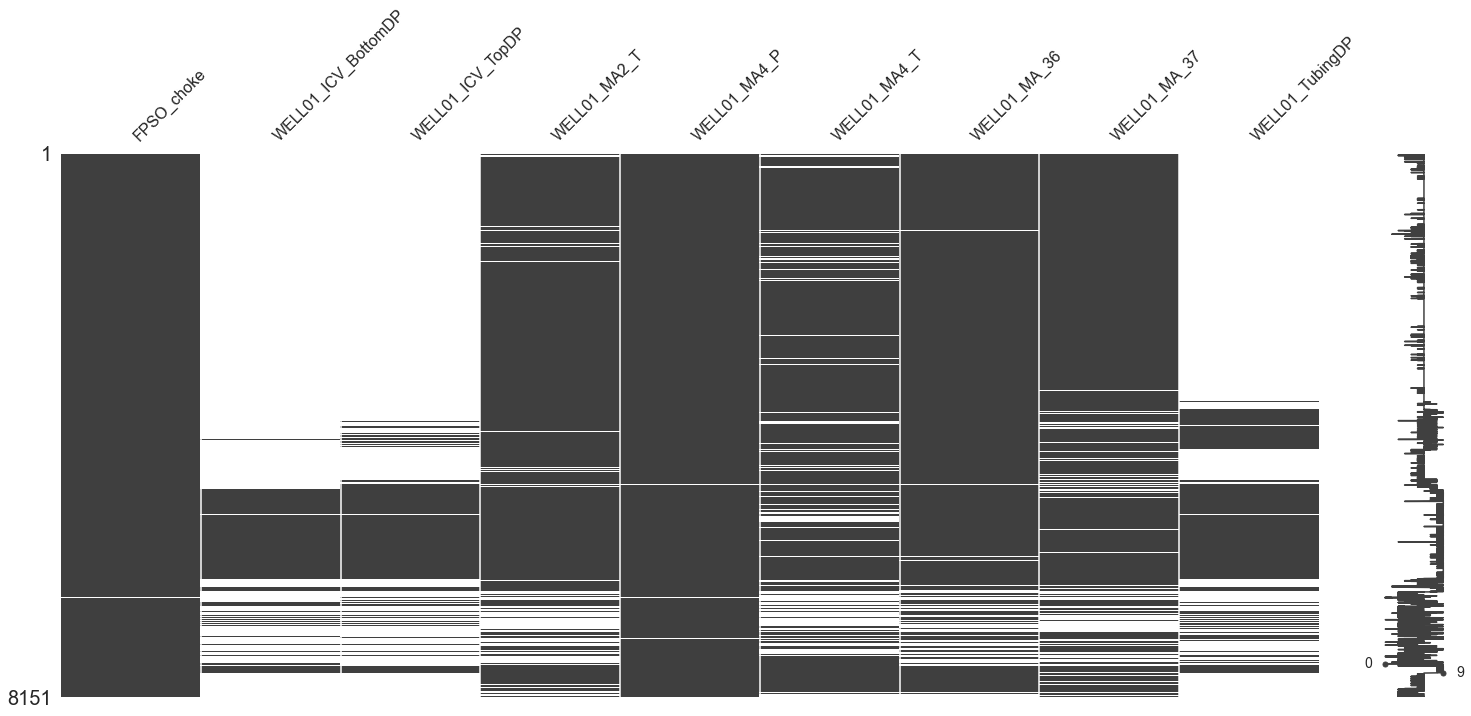

In [7]:
msno.matrix(hourly_means);

In [8]:
hourly_means.reset_index(inplace=True)

In [9]:
hourly_means.head()

,timestamp,FPSO_choke,WELL01_ICV_BottomDP,WELL01_ICV_TopDP,WELL01_MA2_T,WELL01_MA4_P,WELL01_MA4_T,WELL01_MA_36,WELL01_MA_37,WELL01_TubingDP
0,2018-01-01 00:00:00,0.000000,NaN,NaN,86.098450,643.589100,86.112670,NaN,NaN,NaN
1,2018-01-01 02:00:00,10.606346,NaN,NaN,64.565706,584.184957,70.445835,3.623646,260.526945,NaN
2,2018-01-01 03:00:00,5.182946,NaN,NaN,86.090320,643.595746,86.103520,3.575966,260.772181,NaN
3,2018-01-01 04:00:00,6.732144,NaN,NaN,86.089160,643.597516,86.102947,3.547847,261.244367,NaN
4,2018-01-01 05:00:00,8.622501,NaN,NaN,86.084632,643.599004,NaN,3.543044,261.446876,NaN


In [10]:
hourly_means.sort_values(by='timestamp', ascending=True, inplace=True)

In [11]:
hourly_means['Date'] = pd.to_datetime(hourly_means['timestamp']).dt.date
hourly_means

,timestamp,FPSO_choke,WELL01_ICV_BottomDP,WELL01_ICV_TopDP,WELL01_MA2_T,WELL01_MA4_P,WELL01_MA4_T,WELL01_MA_36,WELL01_MA_37,WELL01_TubingDP,Date
0,2018-01-01 00:00:00,0.000000,NaN,NaN,86.098450,643.589100,86.112670,NaN,NaN,NaN,2018-01-01
1,2018-01-01 02:00:00,10.606346,NaN,NaN,64.565706,584.184957,70.445835,3.623646,260.526945,NaN,2018-01-01
2,2018-01-01 03:00:00,5.182946,NaN,NaN,86.090320,643.595746,86.103520,3.575966,260.772181,NaN,2018-01-01
3,2018-01-01 04:00:00,6.732144,NaN,NaN,86.089160,643.597516,86.102947,3.547847,261.244367,NaN,2018-01-01
4,2018-01-01 05:00:00,8.622501,NaN,NaN,86.084632,643.599004,NaN,3.543044,261.446876,NaN,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...
8146,2019-08-21 11:00:00,0.000000,NaN,NaN,NaN,596.576300,NaN,76.239670,NaN,NaN,2019-08-21
8147,2019-08-21 19:00:00,0.000000,NaN,NaN,NaN,596.435700,NaN,NaN,231.161000,NaN,2019-08-21
8148,2019-08-22 03:00:00,0.000000,NaN,NaN,NaN,596.331800,NaN,NaN,231.496500,NaN,2019-08-22
8149,2019-08-22 11:00:00,0.000000,NaN,NaN,NaN,596.212000,NaN,NaN,NaN,NaN,2019-08-22


In [12]:
hourly_means = hourly_means[hourly_means['timestamp'] < '2018-08-24']
hourly_means

,timestamp,FPSO_choke,WELL01_ICV_BottomDP,WELL01_ICV_TopDP,WELL01_MA2_T,WELL01_MA4_P,WELL01_MA4_T,WELL01_MA_36,WELL01_MA_37,WELL01_TubingDP,Date
0,2018-01-01 00:00:00,0.000000,NaN,NaN,86.098450,643.589100,86.112670,NaN,NaN,NaN,2018-01-01
1,2018-01-01 02:00:00,10.606346,NaN,NaN,64.565706,584.184957,70.445835,3.623646,260.526945,NaN,2018-01-01
2,2018-01-01 03:00:00,5.182946,NaN,NaN,86.090320,643.595746,86.103520,3.575966,260.772181,NaN,2018-01-01
3,2018-01-01 04:00:00,6.732144,NaN,NaN,86.089160,643.597516,86.102947,3.547847,261.244367,NaN,2018-01-01
4,2018-01-01 05:00:00,8.622501,NaN,NaN,86.084632,643.599004,NaN,3.543044,261.446876,NaN,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...
5534,2018-08-23 19:00:00,99.921210,5.185328,0.821840,88.720465,593.812423,88.248254,75.992598,160.862694,593.836189,2018-08-23
5535,2018-08-23 20:00:00,99.919393,5.275234,0.690537,88.716515,593.294699,88.304372,75.977932,160.674506,593.310587,2018-08-23
5536,2018-08-23 21:00:00,99.919654,5.352010,0.659456,88.712565,592.857871,88.373927,75.968254,160.505188,592.871329,2018-08-23
5537,2018-08-23 22:00:00,99.920491,5.414372,0.647897,88.712565,592.501657,88.394490,75.933150,160.724448,592.513474,2018-08-23


In [13]:
first_n_last = pd.DataFrame()
for day in hourly_means['Date'].unique():
    df_aux = hourly_means[hourly_means['Date'] == day]
    first_n_last = pd.concat([first_n_last, df_aux.head(1)])
    first_n_last = pd.concat([first_n_last, df_aux.tail(1)])

In [14]:
first_n_last.reset_index(inplace=True)

In [15]:
first_n_last

,index,timestamp,FPSO_choke,WELL01_ICV_BottomDP,WELL01_ICV_TopDP,WELL01_MA2_T,WELL01_MA4_P,WELL01_MA4_T,WELL01_MA_36,WELL01_MA_37,WELL01_TubingDP,Date
0,0,2018-01-01 00:00:00,0.000000,NaN,NaN,86.098450,643.589100,86.112670,NaN,NaN,NaN,2018-01-01
1,16,2018-01-01 23:00:00,0.000000,NaN,NaN,86.045610,643.608020,86.053150,3.575966,262.027200,NaN,2018-01-01
2,17,2018-01-02 00:00:00,0.000000,NaN,NaN,86.045610,643.609483,86.053150,3.575966,261.971283,NaN,2018-01-02
3,32,2018-01-02 23:00:00,0.000000,NaN,NaN,85.996810,643.626475,85.998190,3.540206,260.852950,NaN,2018-01-02
4,33,2018-01-03 00:00:00,0.000000,NaN,NaN,85.996810,643.626600,85.998190,3.528286,261.020700,NaN,2018-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...
465,5490,2018-08-21 23:00:00,99.929620,15.877379,88.556324,89.542159,551.051082,NaN,76.224770,162.879360,551.052355,2018-08-21
466,5491,2018-08-22 00:00:00,99.929292,15.892499,88.591848,89.542310,551.021986,NaN,76.225827,162.942267,551.018452,2018-08-22
467,5514,2018-08-22 23:00:00,99.926080,11.112144,83.149568,89.533660,556.434525,89.615872,76.455550,158.572399,556.444183,2018-08-22
468,5515,2018-08-23 00:00:00,99.926324,11.142494,83.403273,89.463080,556.186696,89.521695,76.404563,158.522788,556.192684,2018-08-23


### Discarding variables not used in simulations

In [16]:
first_n_last = first_n_last[['Date', 'WELL01_MA4_P', 'WELL01_MA_37', 'WELL01_MA_36',
                          'WELL01_MA4_T', 'WELL01_MA2_T']]
first_n_last

,Date,WELL01_MA4_P,WELL01_MA_37,WELL01_MA_36,WELL01_MA4_T,WELL01_MA2_T
0,2018-01-01,643.589100,NaN,NaN,86.112670,86.098450
1,2018-01-01,643.608020,262.027200,3.575966,86.053150,86.045610
2,2018-01-02,643.609483,261.971283,3.575966,86.053150,86.045610
3,2018-01-02,643.626475,260.852950,3.540206,85.998190,85.996810
4,2018-01-03,643.626600,261.020700,3.528286,85.998190,85.996810
...,...,...,...,...,...,...
465,2018-08-21,551.051082,162.879360,76.224770,NaN,89.542159
466,2018-08-22,551.021986,162.942267,76.225827,NaN,89.542310
467,2018-08-22,556.434525,158.572399,76.455550,89.615872,89.533660
468,2018-08-23,556.186696,158.522788,76.404563,89.521695,89.463080


### Converting the PI tags to the names used in simulation, and adding the drop pressures in the same way

In [17]:
first_n_last.loc[:, 'P_bottom'] = first_n_last.loc[:, 'WELL01_MA4_P']
first_n_last.loc[:, 'P_Z0'] = first_n_last.loc[:, 'P_bottom'] + 100 + random.normalvariate(100, 6.314231)
first_n_last.loc[:, 'P_Z1'] = first_n_last.loc[:, 'P_bottom'] + 70 + random.normalvariate(100, 6.314231)
first_n_last.loc[:, 'P_WH'] = first_n_last.loc[:, 'WELL01_MA_37']
first_n_last.loc[:, 'T_Z0'] = first_n_last.loc[:, 'WELL01_MA4_T']
first_n_last.loc[:, 'T_Z1'] = first_n_last.loc[:, 'WELL01_MA2_T']
first_n_last.loc[:, 'T_WH'] = first_n_last.loc[:, 'WELL01_MA_36']
first_n_last.drop(columns=['WELL01_MA4_P', 'WELL01_MA_37', 'WELL01_MA4_T',
                           'WELL01_MA2_T', 'WELL01_MA_36'], inplace=True)
first_n_last

,Date,P_bottom,P_Z0,P_Z1,P_WH,T_Z0,T_Z1,T_WH
0,2018-01-01,643.589100,853.061340,816.967413,NaN,86.112670,86.098450,NaN
1,2018-01-01,643.608020,853.080260,816.986333,262.027200,86.053150,86.045610,3.575966
2,2018-01-02,643.609483,853.081724,816.987796,261.971283,86.053150,86.045610,3.575966
3,2018-01-02,643.626475,853.098715,817.004788,260.852950,85.998190,85.996810,3.540206
4,2018-01-03,643.626600,853.098840,817.004913,261.020700,85.998190,85.996810,3.528286
...,...,...,...,...,...,...,...,...
465,2018-08-21,551.051082,760.523322,724.429394,162.879360,NaN,89.542159,76.224770
466,2018-08-22,551.021986,760.494226,724.400298,162.942267,NaN,89.542310,76.225827
467,2018-08-22,556.434525,765.906765,729.812838,158.572399,89.615872,89.533660,76.455550
468,2018-08-23,556.186696,765.658937,729.565009,158.522788,89.521695,89.463080,76.404563


### Calculating the deltas of quantities and reshaping

In [18]:
cols = [col for col in first_n_last.columns if first_n_last[col].dtype=='float64']
cols

['P_bottom', 'P_Z0', 'P_Z1', 'P_WH', 'T_Z0', 'T_Z1', 'T_WH']

In [19]:
# Even rows = before
# Odd rows = after
# Delta = after - before
before_after = pd.DataFrame()
before_after['Date'] = first_n_last['Date'].iloc[lambda x: x.index % 2 == 0].reset_index(drop=True)

In [20]:
for col in cols:
    before_after[col+'_before'] = first_n_last.loc[lambda x: x.index % 2 == 0, col].reset_index(drop=True)
    before_after[col+'_after'] = first_n_last.loc[lambda x: x.index % 2 == 1, col].reset_index(drop=True)
    before_after[col+'_delta'] = before_after[col+'_after'] - before_after[col+'_before']

In [21]:
before_after

,Date,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,P_Z1_after,P_Z1_delta,...,P_WH_delta,T_Z0_before,T_Z0_after,T_Z0_delta,T_Z1_before,T_Z1_after,T_Z1_delta,T_WH_before,T_WH_after,T_WH_delta
0,2018-01-01,643.589100,643.608020,0.018920,853.061340,853.080260,0.018920,816.967413,816.986333,0.018920,...,NaN,86.112670,86.053150,-0.059520,86.098450,86.045610,-0.052840,NaN,3.575966,NaN
1,2018-01-02,643.609483,643.626475,0.016992,853.081724,853.098715,0.016992,816.987796,817.004788,0.016992,...,-1.118333,86.053150,85.998190,-0.054960,86.045610,85.996810,-0.048800,3.575966,3.540206,-0.035760
2,2018-01-03,643.626600,643.643800,0.017200,853.098840,853.116040,0.017200,817.004913,817.022113,0.017200,...,-1.006500,85.998190,NaN,NaN,85.996810,NaN,NaN,3.528286,3.528286,0.000000
3,2018-01-04,643.644300,643.659800,0.015500,853.116540,853.132040,0.015500,817.022613,817.038113,0.015500,...,-0.503250,85.943190,85.888160,-0.055030,85.952060,85.903210,-0.048850,3.528286,3.521475,-0.006811
4,2018-01-05,643.659800,643.673700,0.013900,853.132040,853.145940,0.013900,817.038113,817.052013,0.013900,...,-0.335500,85.888160,85.833100,-0.055060,85.899140,85.854340,-0.044800,3.528286,3.575966,0.047680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,2018-08-19,554.930564,552.103200,-2.827364,764.402804,761.575440,-2.827364,728.308877,725.481513,-2.827364,...,-1.226043,89.277485,NaN,NaN,89.243822,89.495320,0.251498,76.030053,76.224453,0.194400
231,2018-08-20,552.084726,551.859215,-0.225511,761.556967,761.331456,-0.225511,725.463039,725.237528,-0.225511,...,0.405950,NaN,NaN,NaN,89.496375,89.507070,0.010695,76.224066,76.224122,0.000057
232,2018-08-21,551.821387,551.051082,-0.770305,761.293627,760.523322,-0.770305,725.199699,724.429394,-0.770305,...,2.699610,NaN,NaN,NaN,89.509030,89.542159,0.033129,76.224836,76.224770,-0.000066
233,2018-08-22,551.021986,556.434525,5.412539,760.494226,765.906765,5.412539,724.400298,729.812838,5.412539,...,-4.369868,NaN,89.615872,NaN,89.542310,89.533660,-0.008650,76.225827,76.455550,0.229723


In [22]:
df_test = before_after.reset_index()

## ICV Action History

In [23]:
# Loading data of ICV action
icv_action = pd.read_csv('../raw_data/acionamentos.csv')
icv_action.rename(columns={'Data': 'Date'}, inplace=True)
icv_action

,Date,Tipo de Acionamento,Status,Tipo de Falha,Fase,Top_ICV_Status_Ant,Top_ICV_Status_Pos,Bottom_ICV_Status_Ant,Bottom_ICV_Status_Pos,Pressurizações,Observações
0,10/22/16,Abertura simultânea,ok,NaN,Completação,Fechada,Fechada,Aberta,Aberta,NaN,Abertura simulânea para tratamento ácido
1,10/23/16,Fechamento da ICV inferior,ok,NaN,Completação,Aberta,Aberta,Aberta,Fechada,NaN,Fechamento da zona inferior para tratamento do...
2,10/24/16,Abertura da ICV inferior,ok,NaN,Completação,Aberta,Fechada,Aberta,Aberta,NaN,Abertura do intervalo inferior para deslocamen...
3,10/24/16,Fechamento da ICV inferior,Falho,Vazamento de ICV inferior,Completação,Aberta,Aberta,Abeta,Aberta,NaN,Fechamento da zona inferior para tratamento do...
4,10/24/16,Fechamento da ICV inferior,ok,NaN,Completação,Aberta,Aberta,Abeta,Fechada,NaN,Nova tentativa de fechamento
...,...,...,...,...,...,...,...,...,...,...,...
77,08/21/18,Abertura da ICV superior,Falho,Dificuldade para ciclagem da zona superior,Produção,Fechada,Aberta,Fechada,Aberta,6hrs 30min / 12hrs 55min,Efetuados 2 steps longos de abertura da ICV su...
78,08/21/18,Abertura da ICV superior,Falho,Dificuldade para ciclagem da zona superior,Produção,Fechada,Aberta,Fechada,Aberta,15min/15min,Efetuado ciclo completo de 10 steps para abert...
79,08/22/18,Fechamento da zona inferior (erro de lógica do...,Falho,Fechamento parcial da zona inferior,Produção,Fechada,Aberta,Fechada,Parcialmente aberta,30min (zona superior calçada),"Devido à erro de lógica do Smart Wellmaster, f..."
80,08/22/18,Abertura da ICV inferior,ok,NaN,Produção,Fechada,Parcialmente aberta,Fechada,Aberta,15min/15min,Efetuado ciclo completo de 10 steps para abert...


In [24]:
icv_action.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Date                   82 non-null     object
 1   Tipo de Acionamento    82 non-null     object
 2   Status                 78 non-null     object
 3   Tipo de Falha          49 non-null     object
 4   Fase                   82 non-null     object
 5   Top_ICV_Status_Ant     82 non-null     object
 6   Top_ICV_Status_Pos     82 non-null     object
 7   Bottom_ICV_Status_Ant  82 non-null     object
 8   Bottom_ICV_Status_Pos  82 non-null     object
 9   Pressurizações         73 non-null     object
 10  Observações            81 non-null     object
dtypes: object(11)
memory usage: 7.2+ KB


In [25]:
icv_action['Date'].value_counts()

08/14/18    6
07/13/18    5
10/24/16    5
08/13/18    4
08/16/18    4
07/11/18    4
07/12/18    3
08/12/18    3
08/15/18    3
08/11/18    3
11/25/17    3
01/13/18    2
01/11/18    2
01/09/18    2
12/11/17    2
02/04/18    2
02/13/18    2
08/21/18    2
08/22/18    2
01/15/18    2
08/04/18    1
10/22/16    1
08/06/18    1
08/18/18    1
08/17/18    1
05/28/18    1
07/04/18    1
06/11/18    1
06/10/18    1
05/30/18    1
10/23/16    1
04/05/18    1
04/03/18    1
02/15/18    1
02/03/18    1
02/02/18    1
01/19/18    1
01/18/18    1
11/06/16    1
10/25/16    1
08/23/18    1
Name: Date, dtype: int64

In [26]:
icv_action['Date'].value_counts().count()

41

### Facts
- Days observed for test: 235 (PI data)
- Days with valve action: 41 (cell above)
- Days without valve action: 235 - 41 = 194
- The data from these 194 days may be tested separately, since there is no need to suppose anything about failures in those data.

## Merging PI data and ICV action history

In [27]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            235 non-null    int64  
 1   Date             235 non-null    object 
 2   P_bottom_before  235 non-null    float64
 3   P_bottom_after   235 non-null    float64
 4   P_bottom_delta   235 non-null    float64
 5   P_Z0_before      235 non-null    float64
 6   P_Z0_after       235 non-null    float64
 7   P_Z0_delta       235 non-null    float64
 8   P_Z1_before      235 non-null    float64
 9   P_Z1_after       235 non-null    float64
 10  P_Z1_delta       235 non-null    float64
 11  P_WH_before      222 non-null    float64
 12  P_WH_after       219 non-null    float64
 13  P_WH_delta       207 non-null    float64
 14  T_Z0_before      215 non-null    float64
 15  T_Z0_after       214 non-null    float64
 16  T_Z0_delta       199 non-null    float64
 17  T_Z1_before     

In [28]:
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   index            235 non-null    int64         
 1   Date             235 non-null    datetime64[ns]
 2   P_bottom_before  235 non-null    float64       
 3   P_bottom_after   235 non-null    float64       
 4   P_bottom_delta   235 non-null    float64       
 5   P_Z0_before      235 non-null    float64       
 6   P_Z0_after       235 non-null    float64       
 7   P_Z0_delta       235 non-null    float64       
 8   P_Z1_before      235 non-null    float64       
 9   P_Z1_after       235 non-null    float64       
 10  P_Z1_delta       235 non-null    float64       
 11  P_WH_before      222 non-null    float64       
 12  P_WH_after       219 non-null    float64       
 13  P_WH_delta       207 non-null    float64       
 14  T_Z0_before      215 non-null    float64  

In [29]:
df_test.head()

,index,Date,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,P_Z1_after,...,P_WH_delta,T_Z0_before,T_Z0_after,T_Z0_delta,T_Z1_before,T_Z1_after,T_Z1_delta,T_WH_before,T_WH_after,T_WH_delta
0,0,2018-01-01,643.589100,643.608020,0.018920,853.061340,853.080260,0.018920,816.967413,816.986333,...,NaN,86.11267,86.05315,-0.05952,86.09845,86.04561,-0.05284,NaN,3.575966,NaN
1,1,2018-01-02,643.609483,643.626475,0.016992,853.081724,853.098715,0.016992,816.987796,817.004788,...,-1.118333,86.05315,85.99819,-0.05496,86.04561,85.99681,-0.04880,3.575966,3.540206,-0.035760
2,2,2018-01-03,643.626600,643.643800,0.017200,853.098840,853.116040,0.017200,817.004913,817.022113,...,-1.006500,85.99819,NaN,NaN,85.99681,NaN,NaN,3.528286,3.528286,0.000000
3,3,2018-01-04,643.644300,643.659800,0.015500,853.116540,853.132040,0.015500,817.022613,817.038113,...,-0.503250,85.94319,85.88816,-0.05503,85.95206,85.90321,-0.04885,3.528286,3.521475,-0.006811
4,4,2018-01-05,643.659800,643.673700,0.013900,853.132040,853.145940,0.013900,817.038113,817.052013,...,-0.335500,85.88816,85.83310,-0.05506,85.89914,85.85434,-0.04480,3.528286,3.575966,0.047680


In [30]:
icv_action['Date'] = pd.to_datetime(icv_action['Date'])
icv_action.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   82 non-null     datetime64[ns]
 1   Tipo de Acionamento    82 non-null     object        
 2   Status                 78 non-null     object        
 3   Tipo de Falha          49 non-null     object        
 4   Fase                   82 non-null     object        
 5   Top_ICV_Status_Ant     82 non-null     object        
 6   Top_ICV_Status_Pos     82 non-null     object        
 7   Bottom_ICV_Status_Ant  82 non-null     object        
 8   Bottom_ICV_Status_Pos  82 non-null     object        
 9   Pressurizações         73 non-null     object        
 10  Observações            81 non-null     object        
dtypes: datetime64[ns](1), object(10)
memory usage: 7.2+ KB


In [31]:
icv_action.head()

,Date,Tipo de Acionamento,Status,Tipo de Falha,Fase,Top_ICV_Status_Ant,Top_ICV_Status_Pos,Bottom_ICV_Status_Ant,Bottom_ICV_Status_Pos,Pressurizações,Observações
0,2016-10-22,Abertura simultânea,ok,NaN,Completação,Fechada,Fechada,Aberta,Aberta,NaN,Abertura simulânea para tratamento ácido
1,2016-10-23,Fechamento da ICV inferior,ok,NaN,Completação,Aberta,Aberta,Aberta,Fechada,NaN,Fechamento da zona inferior para tratamento do...
2,2016-10-24,Abertura da ICV inferior,ok,NaN,Completação,Aberta,Fechada,Aberta,Aberta,NaN,Abertura do intervalo inferior para deslocamen...
3,2016-10-24,Fechamento da ICV inferior,Falho,Vazamento de ICV inferior,Completação,Aberta,Aberta,Abeta,Aberta,NaN,Fechamento da zona inferior para tratamento do...
4,2016-10-24,Fechamento da ICV inferior,ok,NaN,Completação,Aberta,Aberta,Abeta,Fechada,NaN,Nova tentativa de fechamento


In [32]:
df_test.columns

Index(['index', 'Date', 'P_bottom_before', 'P_bottom_after', 'P_bottom_delta',
       'P_Z0_before', 'P_Z0_after', 'P_Z0_delta', 'P_Z1_before', 'P_Z1_after',
       'P_Z1_delta', 'P_WH_before', 'P_WH_after', 'P_WH_delta', 'T_Z0_before',
       'T_Z0_after', 'T_Z0_delta', 'T_Z1_before', 'T_Z1_after', 'T_Z1_delta',
       'T_WH_before', 'T_WH_after', 'T_WH_delta'],
      dtype='object')

In [33]:
icv_action.columns

Index(['Date', 'Tipo de Acionamento', 'Status', 'Tipo de Falha', 'Fase',
       'Top_ICV_Status_Ant', 'Top_ICV_Status_Pos', 'Bottom_ICV_Status_Ant',
       'Bottom_ICV_Status_Pos', 'Pressurizações', 'Observações'],
      dtype='object')

In [34]:
# Merging data_input with icv_action
df_test = pd.merge(df_test, icv_action, on='Date', how='left')
df_test.drop(columns=['Tipo de Falha', 'Fase', 'Pressurizações', 'Observações'], inplace=True)
df_test.drop_duplicates(inplace=True)
df_test

,index,Date,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,P_Z1_after,...,T_Z1_delta,T_WH_before,T_WH_after,T_WH_delta,Tipo de Acionamento,Status,Top_ICV_Status_Ant,Top_ICV_Status_Pos,Bottom_ICV_Status_Ant,Bottom_ICV_Status_Pos
0,0,2018-01-01,643.589100,643.608020,0.018920,853.061340,853.080260,0.018920,816.967413,816.986333,...,-0.052840,NaN,3.575966,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2018-01-02,643.609483,643.626475,0.016992,853.081724,853.098715,0.016992,816.987796,817.004788,...,-0.048800,3.575966,3.540206,-0.035760,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2018-01-03,643.626600,643.643800,0.017200,853.098840,853.116040,0.017200,817.004913,817.022113,...,NaN,3.528286,3.528286,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2018-01-04,643.644300,643.659800,0.015500,853.116540,853.132040,0.015500,817.022613,817.038113,...,-0.048850,3.528286,3.521475,-0.006811,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2018-01-05,643.659800,643.673700,0.013900,853.132040,853.145940,0.013900,817.038113,817.052013,...,-0.044800,3.528286,3.575966,0.047680,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,231,2018-08-20,552.084726,551.859215,-0.225511,761.556967,761.331456,-0.225511,725.463039,725.237528,...,0.010695,76.224066,76.224122,0.000057,NaN,NaN,NaN,NaN,NaN,NaN
264,232,2018-08-21,551.821387,551.051082,-0.770305,761.293627,760.523322,-0.770305,725.199699,724.429394,...,0.033129,76.224836,76.224770,-0.000066,Abertura da ICV superior,Falho,Fechada,Aberta,Fechada,Aberta
266,233,2018-08-22,551.021986,556.434525,5.412539,760.494226,765.906765,5.412539,724.400298,729.812838,...,-0.008650,76.225827,76.455550,0.229723,Fechamento da zona inferior (erro de lógica do...,Falho,Fechada,Aberta,Fechada,Parcialmente aberta
267,233,2018-08-22,551.021986,556.434525,5.412539,760.494226,765.906765,5.412539,724.400298,729.812838,...,-0.008650,76.225827,76.455550,0.229723,Abertura da ICV inferior,ok,Fechada,Parcialmente aberta,Fechada,Aberta


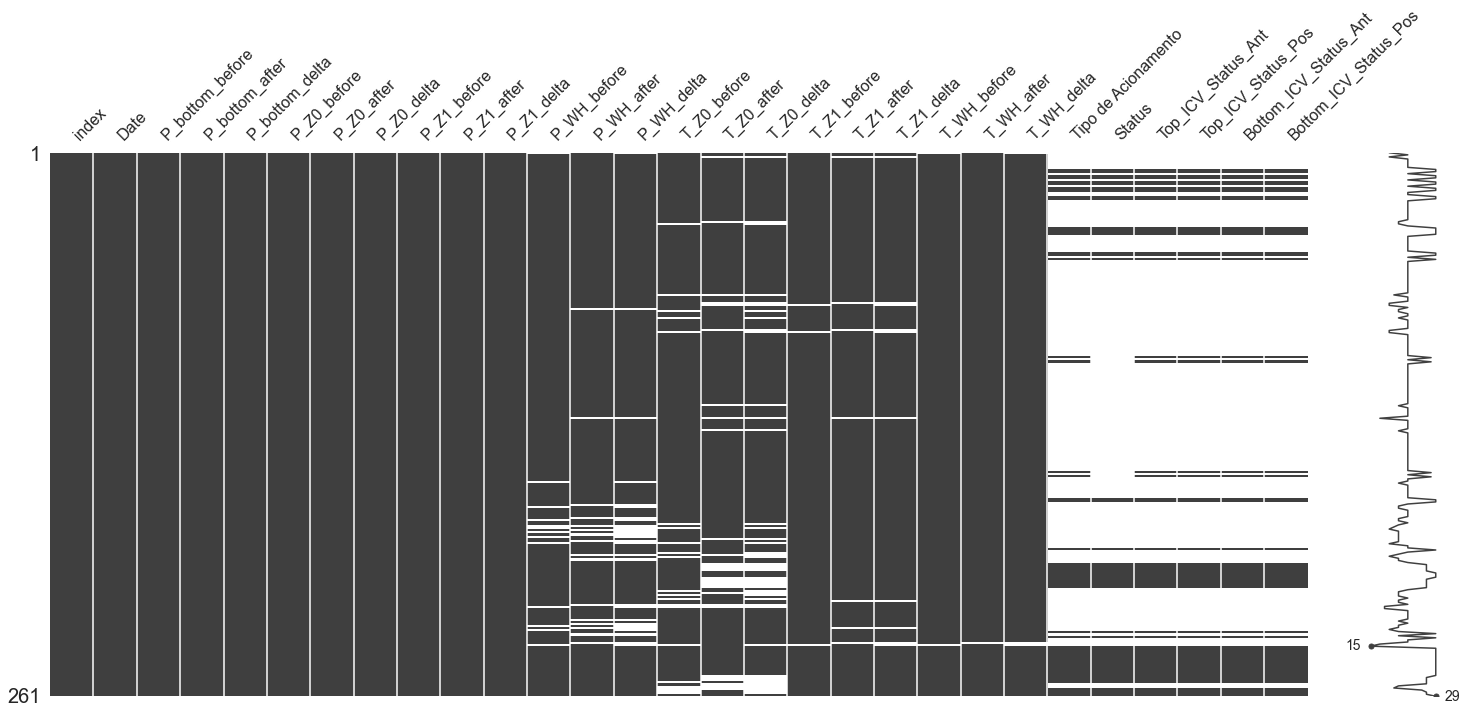

In [35]:
msno.matrix(df_test);

## Comparing to the data fed to machine learning models

In [36]:
df_train = joblib.load('../outputs/models/train_data.pkl')
df_train

,P_Z0_before,P_Z0_after,P_Z1_before,P_Z1_after,P_WH_before,P_WH_after,T_Z0_before,T_Z0_after,T_Z1_before,T_Z1_after,...,P_Z1_delta,P_Z0_delta,P_WH_delta,P_bottom_delta,T_WH_delta,command_type_0,command_type_1,command_type_2,command_type_3,command_type_4
0,782.991774,781.513238,721.997335,732.645404,228.072793,222.739237,88.990443,88.017064,88.256267,91.844784,...,10.648068,-1.478536,-5.333556,-69.947280,1.747713,1.0,0.0,0.0,0.0,0.0
1,823.407968,836.298427,785.214298,786.737540,114.380874,109.468553,85.859813,88.941707,90.356803,87.281548,...,1.523242,12.890459,-4.912321,101.261721,-0.041565,0.0,0.0,0.0,1.0,0.0
2,783.162356,781.606394,727.905276,727.690796,224.554990,230.421390,89.138396,88.773388,89.711909,88.672596,...,-0.214480,-1.555962,5.866400,-0.852047,-1.229892,0.0,0.0,1.0,0.0,0.0
3,782.434641,799.091495,725.812266,725.502688,217.380665,222.701668,88.840552,89.561738,88.047662,87.951192,...,-0.309578,16.656854,5.321003,-75.381007,-3.491265,1.0,0.0,0.0,0.0,0.0
4,845.024456,830.298714,778.727926,791.655508,105.516327,111.314215,85.680819,86.664650,89.330981,86.211135,...,12.927583,-14.725742,5.797888,11.028805,-2.603948,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,787.271113,781.998460,710.195918,716.790706,227.571746,222.070860,88.276114,86.481481,88.353872,88.491776,...,6.594787,-5.272653,-5.500886,-45.014137,-5.753539,0.0,1.0,0.0,0.0,0.0
9996,810.406086,794.551916,752.353625,750.208143,228.402031,224.036259,88.164860,87.298385,88.116074,90.366115,...,-2.145482,-15.854170,-4.365773,37.107424,5.332383,0.0,0.0,0.0,0.0,1.0
9997,787.086793,785.018482,732.677958,722.580568,223.745255,226.726036,89.784324,87.503559,89.757217,89.826107,...,-10.097390,-2.068311,2.980780,-4.265735,-1.839192,1.0,0.0,0.0,0.0,0.0
9998,850.027606,845.226598,774.510375,793.817333,115.348739,110.382150,87.331351,89.311389,84.625393,85.116316,...,19.306958,-4.801008,-4.966590,-101.104098,-1.986409,1.0,0.0,0.0,0.0,0.0


## Cleaning Type of valve action

In [37]:
# Encoded labels
# df_train['Type'].value_counts()

In [38]:
df_test['Tipo de Acionamento'].value_counts()

Abertura da ICV superior                               22
Abertura da ICV inferior                               18
Fechamento da ICV superior                             16
Fechamento da ICV inferior                              1
Fechamento simultâneo                                   1
Pressurização de todas as linhas                        1
Fechamento da zona inferior (erro de lógica do SWM)     1
Name: Tipo de Acionamento, dtype: int64

In [39]:
# Using the same labels
df_test['Tipo de Acionamento'].replace({'Abertura da ICV inferior': 'Open_Bottom',
                                        'Fechamento da ICV inferior': 'Close_Bottom',
                                        'Abertura da ICV superior': 'Open_Top',
                                        'Fechamento da ICV superior': 'Close_Top',
                                        'Fechamento simultâneo': 'Close_Bottom', #garbage
                                        'Pressurização de todas as linhas': 'Close_Bottom', #garbage
                                        'Fechamento da zona inferior (erro de lógica do SWM)': 'Close_Bottom' #garbage
                                       }, inplace=True)

In [40]:
df_test['Tipo de Acionamento'].value_counts()

Open_Top        22
Open_Bottom     18
Close_Top       16
Close_Bottom     4
Name: Tipo de Acionamento, dtype: int64

In [41]:
df_test.rename(columns={'Tipo de Acionamento': 'command_type'}, inplace=True)

In [42]:
df_test['command_type'] = df_test['command_type'].fillna('No-action')

## For days with more than one action: assume they were registered in chronological order to fill the missing ICV status.

In [43]:
# Days with more than one valve action:
df_test['Date'].value_counts()[df_test['Date'].value_counts()>1]

2018-07-13    5
2018-07-11    4
2018-08-13    4
2018-07-12    3
2018-08-11    3
2018-08-12    3
2018-02-04    2
2018-08-15    2
2018-01-15    2
2018-08-14    2
2018-01-13    2
2018-01-11    2
2018-08-16    2
2018-01-09    2
2018-02-13    2
2018-08-22    2
Name: Date, dtype: int64

In [44]:
list_of_days = df_test['Date'].value_counts()[df_test['Date'].value_counts()>1].index
list_of_days

DatetimeIndex(['2018-07-13', '2018-07-11', '2018-08-13', '2018-07-12',
               '2018-08-11', '2018-08-12', '2018-02-04', '2018-08-15',
               '2018-01-15', '2018-08-14', '2018-01-13', '2018-01-11',
               '2018-08-16', '2018-01-09', '2018-02-13', '2018-08-22'],
              dtype='datetime64[ns]', freq=None)

In [45]:
df_test[df_test['Date'] == '2018-07-13']

,index,Date,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,P_Z1_after,...,T_Z1_delta,T_WH_before,T_WH_after,T_WH_delta,command_type,Status,Top_ICV_Status_Ant,Top_ICV_Status_Pos,Bottom_ICV_Status_Ant,Bottom_ICV_Status_Pos
204,193,2018-07-13,517.758617,591.715255,73.956638,727.230858,801.187495,73.956638,691.13693,765.093568,...,-1.878429,74.890039,75.619829,0.72979,Open_Top,Falho,Fechada,Parcialmente aberta,Parcialmente aberta,Parcialmente aberta
205,193,2018-07-13,517.758617,591.715255,73.956638,727.230858,801.187495,73.956638,691.13693,765.093568,...,-1.878429,74.890039,75.619829,0.72979,Open_Top,Falho,Parcialmente aberta,Parcialmente aberta,Parcialmente aberta,Parcialmente aberta
206,193,2018-07-13,517.758617,591.715255,73.956638,727.230858,801.187495,73.956638,691.13693,765.093568,...,-1.878429,74.890039,75.619829,0.72979,Open_Bottom,ok,Parcialmente aberta,Parcialmente aberta,Parcialmente aberta,Aberta
207,193,2018-07-13,517.758617,591.715255,73.956638,727.230858,801.187495,73.956638,691.13693,765.093568,...,-1.878429,74.890039,75.619829,0.72979,Open_Top,Falho,Parcialmente aberta,Aberta,Parcialmente aberta,Aberta
208,193,2018-07-13,517.758617,591.715255,73.956638,727.230858,801.187495,73.956638,691.13693,765.093568,...,-1.878429,74.890039,75.619829,0.72979,Open_Top,ok,Parcialmente aberta,Aberta,Aberta,Aberta


In [46]:
df_test[df_test['Date'] == '2018-07-13']['Top_ICV_Status_Ant'].iloc[0]

'Fechada'

In [47]:
df_test[df_test['Date'] == '2018-07-13']['Top_ICV_Status_Pos'].iloc[-1]

'Aberta'

In [48]:
for day in list_of_days:
    print('################################################################################')
    print(f'Day: {day}')
    print(f'Length: {df_test[df_test["Date"] == day]["Top_ICV_Status_Ant"].shape}')
    top_icv_status_ant = df_test[df_test['Date'] == day]['Top_ICV_Status_Ant'].iloc[0]
    top_icv_status_pos = df_test[df_test['Date'] == day]['Top_ICV_Status_Pos'].iloc[-1]
    bottom_icv_status_ant = df_test[df_test['Date'] == day]['Bottom_ICV_Status_Ant'].iloc[0]
    bottom_icv_status_pos = df_test[df_test['Date'] == day]['Bottom_ICV_Status_Pos'].iloc[-1]
    
    print(top_icv_status_ant)
    print(top_icv_status_pos)
    print(bottom_icv_status_ant)
    print(bottom_icv_status_pos)
        
    df_test.loc[df_test['Date'] == day, 'Top_ICV_Status_Ant'] = top_icv_status_ant
    df_test.loc[df_test['Date'] == day, 'Top_ICV_Status_Pos'] = top_icv_status_pos
    
    df_test.loc[df_test['Date'] == day, 'Bottom_ICV_Status_Ant'] = bottom_icv_status_ant
    df_test.loc[df_test['Date'] == day, 'Bottom_ICV_Status_Pos'] = bottom_icv_status_pos

    print('################################################################################')

################################################################################
Day: 2018-07-13 00:00:00
Length: (5,)
Fechada
Aberta
Parcialmente aberta
Aberta
################################################################################
################################################################################
Day: 2018-07-11 00:00:00
Length: (4,)
Fechada
Aberta
Parcialmente aberta
Aberta
################################################################################
################################################################################
Day: 2018-08-13 00:00:00
Length: (4,)
Fechada
Aberta
Fechada
Aberta
################################################################################
################################################################################
Day: 2018-07-12 00:00:00
Length: (3,)
Fechada
Parcialmente aberta
Fechada
Parcialmente aberta
################################################################################
##############################

In [49]:
df_test[df_test['Date'] == '2018-07-13']['Top_ICV_Status_Ant']

204    Fechada
205    Fechada
206    Fechada
207    Fechada
208    Fechada
Name: Top_ICV_Status_Ant, dtype: object

In [50]:
df_test[df_test['Date'] == '2018-07-13']['Top_ICV_Status_Pos']

204    Aberta
205    Aberta
206    Aberta
207    Aberta
208    Aberta
Name: Top_ICV_Status_Pos, dtype: object

In [51]:
df_test

,index,Date,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,P_Z1_after,...,T_Z1_delta,T_WH_before,T_WH_after,T_WH_delta,command_type,Status,Top_ICV_Status_Ant,Top_ICV_Status_Pos,Bottom_ICV_Status_Ant,Bottom_ICV_Status_Pos
0,0,2018-01-01,643.589100,643.608020,0.018920,853.061340,853.080260,0.018920,816.967413,816.986333,...,-0.052840,NaN,3.575966,NaN,No-action,NaN,NaN,NaN,NaN,NaN
1,1,2018-01-02,643.609483,643.626475,0.016992,853.081724,853.098715,0.016992,816.987796,817.004788,...,-0.048800,3.575966,3.540206,-0.035760,No-action,NaN,NaN,NaN,NaN,NaN
2,2,2018-01-03,643.626600,643.643800,0.017200,853.098840,853.116040,0.017200,817.004913,817.022113,...,NaN,3.528286,3.528286,0.000000,No-action,NaN,NaN,NaN,NaN,NaN
3,3,2018-01-04,643.644300,643.659800,0.015500,853.116540,853.132040,0.015500,817.022613,817.038113,...,-0.048850,3.528286,3.521475,-0.006811,No-action,NaN,NaN,NaN,NaN,NaN
4,4,2018-01-05,643.659800,643.673700,0.013900,853.132040,853.145940,0.013900,817.038113,817.052013,...,-0.044800,3.528286,3.575966,0.047680,No-action,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,231,2018-08-20,552.084726,551.859215,-0.225511,761.556967,761.331456,-0.225511,725.463039,725.237528,...,0.010695,76.224066,76.224122,0.000057,No-action,NaN,NaN,NaN,NaN,NaN
264,232,2018-08-21,551.821387,551.051082,-0.770305,761.293627,760.523322,-0.770305,725.199699,724.429394,...,0.033129,76.224836,76.224770,-0.000066,Open_Top,Falho,Fechada,Aberta,Fechada,Aberta
266,233,2018-08-22,551.021986,556.434525,5.412539,760.494226,765.906765,5.412539,724.400298,729.812838,...,-0.008650,76.225827,76.455550,0.229723,Close_Bottom,Falho,Fechada,Parcialmente aberta,Fechada,Aberta
267,233,2018-08-22,551.021986,556.434525,5.412539,760.494226,765.906765,5.412539,724.400298,729.812838,...,-0.008650,76.225827,76.455550,0.229723,Open_Bottom,ok,Fechada,Parcialmente aberta,Fechada,Aberta


## Status

In [52]:
df_test['Status'].info()

<class 'pandas.core.series.Series'>
Int64Index: 261 entries, 0 to 268
Series name: Status
Non-Null Count  Dtype 
--------------  ----- 
56 non-null     object
dtypes: object(1)
memory usage: 4.1+ KB


In [53]:
df_test['Status'].value_counts()

Falho    37
ok       19
Name: Status, dtype: int64

In [54]:
# Enconded labels
df_train['action_result']

0       0
1       1
2       1
3       0
4       1
       ..
9995    0
9996    0
9997    0
9998    0
9999    1
Name: action_result, Length: 10000, dtype: int32

In [55]:
# This column is the target to be predicted by the model
# For now let 'Falho' == True, all other cases (ok and NaN) are False, so we can use boolean logic to determine
# if a failure happend in a day
df_test.rename(columns={'Status': 'action_result'}, inplace=True)

In [56]:
df_test['action_result'] = df_test['action_result'].apply(lambda x: True if x == 'Falho' else False)
df_test

,index,Date,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,P_Z1_after,...,T_Z1_delta,T_WH_before,T_WH_after,T_WH_delta,command_type,action_result,Top_ICV_Status_Ant,Top_ICV_Status_Pos,Bottom_ICV_Status_Ant,Bottom_ICV_Status_Pos
0,0,2018-01-01,643.589100,643.608020,0.018920,853.061340,853.080260,0.018920,816.967413,816.986333,...,-0.052840,NaN,3.575966,NaN,No-action,False,NaN,NaN,NaN,NaN
1,1,2018-01-02,643.609483,643.626475,0.016992,853.081724,853.098715,0.016992,816.987796,817.004788,...,-0.048800,3.575966,3.540206,-0.035760,No-action,False,NaN,NaN,NaN,NaN
2,2,2018-01-03,643.626600,643.643800,0.017200,853.098840,853.116040,0.017200,817.004913,817.022113,...,NaN,3.528286,3.528286,0.000000,No-action,False,NaN,NaN,NaN,NaN
3,3,2018-01-04,643.644300,643.659800,0.015500,853.116540,853.132040,0.015500,817.022613,817.038113,...,-0.048850,3.528286,3.521475,-0.006811,No-action,False,NaN,NaN,NaN,NaN
4,4,2018-01-05,643.659800,643.673700,0.013900,853.132040,853.145940,0.013900,817.038113,817.052013,...,-0.044800,3.528286,3.575966,0.047680,No-action,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,231,2018-08-20,552.084726,551.859215,-0.225511,761.556967,761.331456,-0.225511,725.463039,725.237528,...,0.010695,76.224066,76.224122,0.000057,No-action,False,NaN,NaN,NaN,NaN
264,232,2018-08-21,551.821387,551.051082,-0.770305,761.293627,760.523322,-0.770305,725.199699,724.429394,...,0.033129,76.224836,76.224770,-0.000066,Open_Top,True,Fechada,Aberta,Fechada,Aberta
266,233,2018-08-22,551.021986,556.434525,5.412539,760.494226,765.906765,5.412539,724.400298,729.812838,...,-0.008650,76.225827,76.455550,0.229723,Close_Bottom,True,Fechada,Parcialmente aberta,Fechada,Aberta
267,233,2018-08-22,551.021986,556.434525,5.412539,760.494226,765.906765,5.412539,724.400298,729.812838,...,-0.008650,76.225827,76.455550,0.229723,Open_Bottom,False,Fechada,Parcialmente aberta,Fechada,Aberta


In [57]:
df_test['action_result'].value_counts()

False    224
True      37
Name: action_result, dtype: int64

In [58]:
# There are days with more than one action
# Days with more than one valve action:
df_test['Date'].value_counts()[df_test['Date'].value_counts()>1]

2018-07-13    5
2018-07-11    4
2018-08-13    4
2018-07-12    3
2018-08-11    3
2018-08-12    3
2018-02-04    2
2018-08-15    2
2018-01-15    2
2018-08-14    2
2018-01-13    2
2018-01-11    2
2018-08-16    2
2018-01-09    2
2018-02-13    2
2018-08-22    2
Name: Date, dtype: int64

In [59]:
df_test[df_test['Date'] == '2018-07-13']

,index,Date,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,P_Z1_after,...,T_Z1_delta,T_WH_before,T_WH_after,T_WH_delta,command_type,action_result,Top_ICV_Status_Ant,Top_ICV_Status_Pos,Bottom_ICV_Status_Ant,Bottom_ICV_Status_Pos
204,193,2018-07-13,517.758617,591.715255,73.956638,727.230858,801.187495,73.956638,691.13693,765.093568,...,-1.878429,74.890039,75.619829,0.72979,Open_Top,True,Fechada,Aberta,Parcialmente aberta,Aberta
205,193,2018-07-13,517.758617,591.715255,73.956638,727.230858,801.187495,73.956638,691.13693,765.093568,...,-1.878429,74.890039,75.619829,0.72979,Open_Top,True,Fechada,Aberta,Parcialmente aberta,Aberta
206,193,2018-07-13,517.758617,591.715255,73.956638,727.230858,801.187495,73.956638,691.13693,765.093568,...,-1.878429,74.890039,75.619829,0.72979,Open_Bottom,False,Fechada,Aberta,Parcialmente aberta,Aberta
207,193,2018-07-13,517.758617,591.715255,73.956638,727.230858,801.187495,73.956638,691.13693,765.093568,...,-1.878429,74.890039,75.619829,0.72979,Open_Top,True,Fechada,Aberta,Parcialmente aberta,Aberta
208,193,2018-07-13,517.758617,591.715255,73.956638,727.230858,801.187495,73.956638,691.13693,765.093568,...,-1.878429,74.890039,75.619829,0.72979,Open_Top,False,Fechada,Aberta,Parcialmente aberta,Aberta


In [60]:
df_test[df_test['Date'] == '2018-07-13']['action_result'].any()

True

In [61]:
for day in list_of_days:
    print('################################################################################')
    print(f'Day: {day}')
    print(f'Length: {df_test[df_test["Date"] == day]["action_result"].shape}')
    print(df_test[df_test["Date"] == day]["action_result"])
    print('*********** After transformation *****************')
    df_test.loc[df_test['Date'] == day, 'action_result'] = df_test[df_test["Date"] == day]["action_result"].any()
    print(df_test[df_test["Date"] == day]["action_result"])
    print('################################################################################')

################################################################################
Day: 2018-07-13 00:00:00
Length: (5,)
204     True
205     True
206    False
207     True
208    False
Name: action_result, dtype: bool
*********** After transformation *****************
204    True
205    True
206    True
207    True
208    True
Name: action_result, dtype: bool
################################################################################
################################################################################
Day: 2018-07-11 00:00:00
Length: (4,)
197     True
198     True
199    False
200     True
Name: action_result, dtype: bool
*********** After transformation *****************
197    True
198    True
199    True
200    True
Name: action_result, dtype: bool
################################################################################
################################################################################
Day: 2018-08-13 00:00:00
Length: (4,)
243     True
244    Fa

In [62]:
df_test.drop_duplicates(inplace=True)
df_test

,index,Date,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,P_Z1_after,...,T_Z1_delta,T_WH_before,T_WH_after,T_WH_delta,command_type,action_result,Top_ICV_Status_Ant,Top_ICV_Status_Pos,Bottom_ICV_Status_Ant,Bottom_ICV_Status_Pos
0,0,2018-01-01,643.589100,643.608020,0.018920,853.061340,853.080260,0.018920,816.967413,816.986333,...,-0.052840,NaN,3.575966,NaN,No-action,False,NaN,NaN,NaN,NaN
1,1,2018-01-02,643.609483,643.626475,0.016992,853.081724,853.098715,0.016992,816.987796,817.004788,...,-0.048800,3.575966,3.540206,-0.035760,No-action,False,NaN,NaN,NaN,NaN
2,2,2018-01-03,643.626600,643.643800,0.017200,853.098840,853.116040,0.017200,817.004913,817.022113,...,NaN,3.528286,3.528286,0.000000,No-action,False,NaN,NaN,NaN,NaN
3,3,2018-01-04,643.644300,643.659800,0.015500,853.116540,853.132040,0.015500,817.022613,817.038113,...,-0.048850,3.528286,3.521475,-0.006811,No-action,False,NaN,NaN,NaN,NaN
4,4,2018-01-05,643.659800,643.673700,0.013900,853.132040,853.145940,0.013900,817.038113,817.052013,...,-0.044800,3.528286,3.575966,0.047680,No-action,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,231,2018-08-20,552.084726,551.859215,-0.225511,761.556967,761.331456,-0.225511,725.463039,725.237528,...,0.010695,76.224066,76.224122,0.000057,No-action,False,NaN,NaN,NaN,NaN
264,232,2018-08-21,551.821387,551.051082,-0.770305,761.293627,760.523322,-0.770305,725.199699,724.429394,...,0.033129,76.224836,76.224770,-0.000066,Open_Top,True,Fechada,Aberta,Fechada,Aberta
266,233,2018-08-22,551.021986,556.434525,5.412539,760.494226,765.906765,5.412539,724.400298,729.812838,...,-0.008650,76.225827,76.455550,0.229723,Close_Bottom,True,Fechada,Parcialmente aberta,Fechada,Aberta
267,233,2018-08-22,551.021986,556.434525,5.412539,760.494226,765.906765,5.412539,724.400298,729.812838,...,-0.008650,76.225827,76.455550,0.229723,Open_Bottom,True,Fechada,Parcialmente aberta,Fechada,Aberta


In [63]:
df_test['action_result'].value_counts()

False    212
True      42
Name: action_result, dtype: int64

In [64]:
df_test['action_result'] = df_test['action_result'].apply(lambda x: 'Failure' if x else 'Normal')
df_test

,index,Date,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,P_Z1_after,...,T_Z1_delta,T_WH_before,T_WH_after,T_WH_delta,command_type,action_result,Top_ICV_Status_Ant,Top_ICV_Status_Pos,Bottom_ICV_Status_Ant,Bottom_ICV_Status_Pos
0,0,2018-01-01,643.589100,643.608020,0.018920,853.061340,853.080260,0.018920,816.967413,816.986333,...,-0.052840,NaN,3.575966,NaN,No-action,Normal,NaN,NaN,NaN,NaN
1,1,2018-01-02,643.609483,643.626475,0.016992,853.081724,853.098715,0.016992,816.987796,817.004788,...,-0.048800,3.575966,3.540206,-0.035760,No-action,Normal,NaN,NaN,NaN,NaN
2,2,2018-01-03,643.626600,643.643800,0.017200,853.098840,853.116040,0.017200,817.004913,817.022113,...,NaN,3.528286,3.528286,0.000000,No-action,Normal,NaN,NaN,NaN,NaN
3,3,2018-01-04,643.644300,643.659800,0.015500,853.116540,853.132040,0.015500,817.022613,817.038113,...,-0.048850,3.528286,3.521475,-0.006811,No-action,Normal,NaN,NaN,NaN,NaN
4,4,2018-01-05,643.659800,643.673700,0.013900,853.132040,853.145940,0.013900,817.038113,817.052013,...,-0.044800,3.528286,3.575966,0.047680,No-action,Normal,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,231,2018-08-20,552.084726,551.859215,-0.225511,761.556967,761.331456,-0.225511,725.463039,725.237528,...,0.010695,76.224066,76.224122,0.000057,No-action,Normal,NaN,NaN,NaN,NaN
264,232,2018-08-21,551.821387,551.051082,-0.770305,761.293627,760.523322,-0.770305,725.199699,724.429394,...,0.033129,76.224836,76.224770,-0.000066,Open_Top,Failure,Fechada,Aberta,Fechada,Aberta
266,233,2018-08-22,551.021986,556.434525,5.412539,760.494226,765.906765,5.412539,724.400298,729.812838,...,-0.008650,76.225827,76.455550,0.229723,Close_Bottom,Failure,Fechada,Parcialmente aberta,Fechada,Aberta
267,233,2018-08-22,551.021986,556.434525,5.412539,760.494226,765.906765,5.412539,724.400298,729.812838,...,-0.008650,76.225827,76.455550,0.229723,Open_Bottom,Failure,Fechada,Parcialmente aberta,Fechada,Aberta


In [65]:
df_test['action_result'].value_counts()

Normal     212
Failure     42
Name: action_result, dtype: int64

## ICV Status

In [66]:
df_test['Top_ICV_Status_Ant'].value_counts()

Fechada        29
Comunicando    14
Aberta         10
Name: Top_ICV_Status_Ant, dtype: int64

In [67]:
df_test['Top_ICV_Status_Pos'].value_counts()

Aberta                 34
Parcialmente aberta    18
Comunicando             1
Name: Top_ICV_Status_Pos, dtype: int64

In [68]:
df_test['Bottom_ICV_Status_Ant'].value_counts()

Fechada                25
Aberta                 13
Comunicando            10
Parcialmente aberta     5
Name: Bottom_ICV_Status_Ant, dtype: int64

In [69]:
df_test['Bottom_ICV_Status_Pos'].value_counts()

Aberta                 38
Parcialmente aberta    13
Comunicando             2
Name: Bottom_ICV_Status_Pos, dtype: int64

In [70]:
df_test[(df_test['Bottom_ICV_Status_Ant'] == 'Comunicando') | (df_test['Bottom_ICV_Status_Ant'] == 'Comunicando') |\
        (df_test['Top_ICV_Status_Ant'] == 'Comunicando') | (df_test['Top_ICV_Status_Pos'] == 'Comunicando')]

,index,Date,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,P_Z1_after,...,T_Z1_delta,T_WH_before,T_WH_after,T_WH_delta,command_type,action_result,Top_ICV_Status_Ant,Top_ICV_Status_Pos,Bottom_ICV_Status_Ant,Bottom_ICV_Status_Pos
11,10,2018-01-11,612.076611,610.447664,-1.628947,821.548852,819.919904,-1.628947,785.454924,783.825977,...,0.112193,73.127871,73.205740,0.077869,Open_Bottom,Failure,Comunicando,Parcialmente aberta,Comunicando,Parcialmente aberta
12,10,2018-01-11,612.076611,610.447664,-1.628947,821.548852,819.919904,-1.628947,785.454924,783.825977,...,0.112193,73.127871,73.205740,0.077869,Close_Top,Failure,Comunicando,Parcialmente aberta,Comunicando,Parcialmente aberta
14,12,2018-01-13,611.419210,614.745440,3.326230,820.891451,824.217681,3.326230,784.797523,788.123753,...,-0.070223,73.353838,73.508304,0.154466,Open_Bottom,Failure,Comunicando,Parcialmente aberta,Comunicando,Parcialmente aberta
15,12,2018-01-13,611.419210,614.745440,3.326230,820.891451,824.217681,3.326230,784.797523,788.123753,...,-0.070223,73.353838,73.508304,0.154466,Close_Top,Failure,Comunicando,Parcialmente aberta,Comunicando,Parcialmente aberta
17,14,2018-01-15,614.655106,631.999893,17.344787,824.127347,841.472134,17.344787,788.033419,805.378206,...,-0.560278,73.552347,73.905835,0.353489,Close_Top,Failure,Comunicando,Parcialmente aberta,Comunicando,Parcialmente aberta
18,14,2018-01-15,614.655106,631.999893,17.344787,824.127347,841.472134,17.344787,788.033419,805.378206,...,-0.560278,73.552347,73.905835,0.353489,Open_Bottom,Failure,Comunicando,Parcialmente aberta,Comunicando,Parcialmente aberta
21,17,2018-01-18,631.866113,633.435407,1.569295,841.338353,842.907648,1.569295,805.244426,806.813720,...,-0.038447,73.961775,74.085674,0.123899,Close_Top,Failure,Comunicando,Parcialmente aberta,Comunicando,Parcialmente aberta
22,18,2018-01-19,633.492882,633.629458,0.136576,842.965123,843.101699,0.136576,806.871195,807.007771,...,0.004729,74.086142,74.102920,0.016778,Open_Bottom,Failure,Comunicando,Parcialmente aberta,Comunicando,Parcialmente aberta
36,32,2018-02-02,633.091475,642.069518,8.978043,842.563715,851.541758,8.978043,806.469787,815.447831,...,-0.009254,74.478168,44.769431,-29.708737,Open_Bottom,Normal,Comunicando,Parcialmente aberta,Comunicando,Aberta
37,33,2018-02-03,642.230967,632.549976,-9.680990,851.703207,842.022217,-9.680990,815.609280,805.928289,...,0.073852,39.118450,74.654320,35.535870,Close_Top,Failure,Comunicando,Aberta,Comunicando,Aberta


### Filling the gaps:
### Assuming:
- Valve partially open as open (True)
- Valve communicating as open (True)

In [71]:
df_test.reset_index(inplace=True)

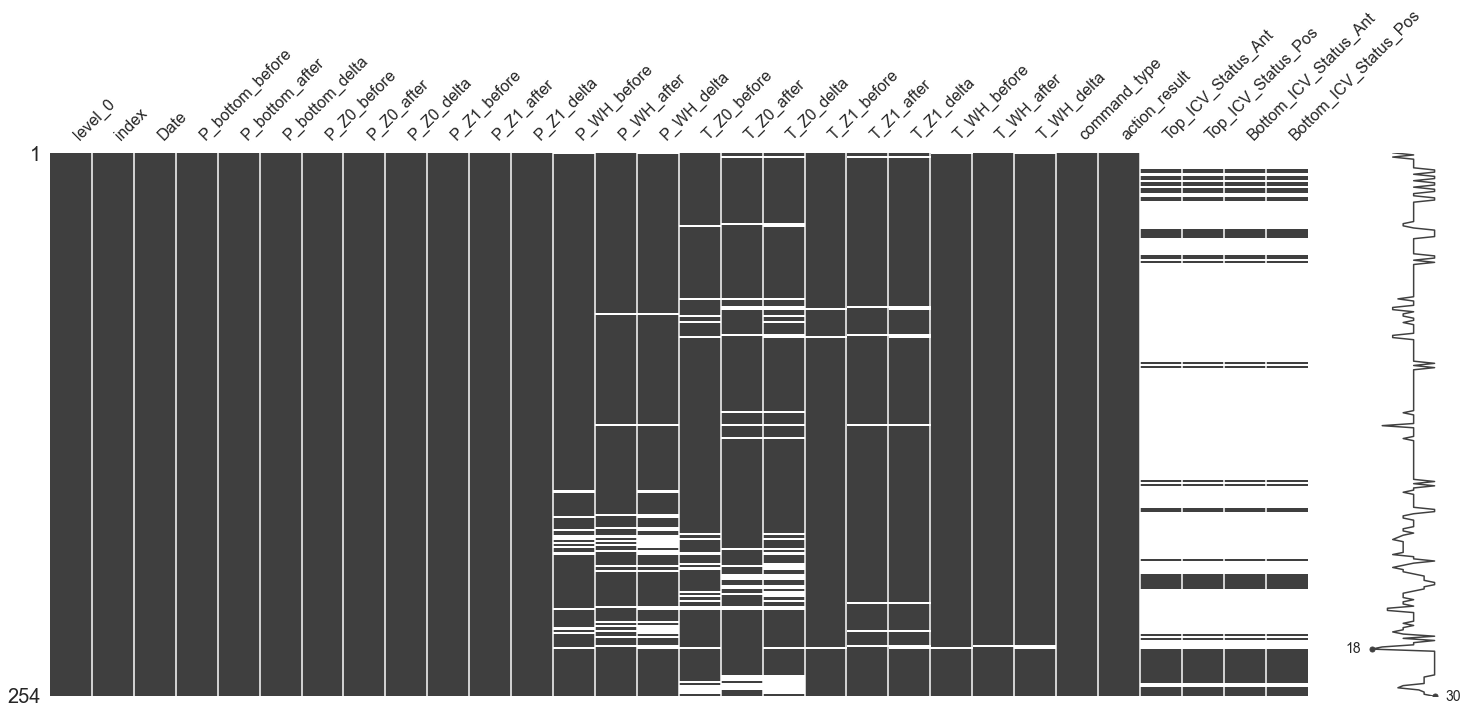

In [72]:
msno.matrix(df_test);

In [73]:
df_test['Top_ICV_Status_Ant'] = df_test['Top_ICV_Status_Ant'].apply(lambda x: False if x == 'Fechada' else\
                                                                                True if x == 'Parcialmente aberta' else\
                                                                                True if x == 'Comunicando' else\
                                                                                True if x == 'Aberta' else\
                                                                                np.nan)

In [74]:
df_test['Top_ICV_Status_Ant'].value_counts()

False    29
True     24
Name: Top_ICV_Status_Ant, dtype: int64

In [75]:
df_test['Top_ICV_Status_Pos'] = df_test['Top_ICV_Status_Pos'].apply(lambda x: False if x == 'Fechada' else\
                                                                                True if x == 'Parcialmente aberta' else\
                                                                                True if x == 'Comunicando' else\
                                                                                True if x == 'Aberta' else\
                                                                                np.nan)
df_test['Top_ICV_Status_Pos'].value_counts()

True    53
Name: Top_ICV_Status_Pos, dtype: int64

In [76]:
df_test['Bottom_ICV_Status_Ant'] = df_test['Bottom_ICV_Status_Ant'].apply(lambda x: False if x == 'Fechada' else\
                                                                                True if x == 'Parcialmente aberta' else\
                                                                                True if x == 'Comunicando' else\
                                                                                True if x == 'Aberta' else\
                                                                                np.nan)
df_test['Bottom_ICV_Status_Ant'].value_counts()

True     28
False    25
Name: Bottom_ICV_Status_Ant, dtype: int64

In [77]:
df_test['Bottom_ICV_Status_Pos'] = df_test['Bottom_ICV_Status_Pos'].apply(lambda x: False if x == 'Fechada' else\
                                                                                True if x == 'Parcialmente aberta' else\
                                                                                True if x == 'Comunicando' else\
                                                                                True if x == 'Aberta' else\
                                                                                np.nan)
df_test['Bottom_ICV_Status_Pos'].value_counts()

True    53
Name: Bottom_ICV_Status_Pos, dtype: int64

In [78]:
# Identifying where there is status change on ICVs:
df_changes = df_test[(df_test['Top_ICV_Status_Ant'] != df_test['Top_ICV_Status_Pos']) & df_test['Top_ICV_Status_Pos'].notna()]
df_changes

,level_0,index,Date,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,...,T_Z1_delta,T_WH_before,T_WH_after,T_WH_delta,command_type,action_result,Top_ICV_Status_Ant,Top_ICV_Status_Pos,Bottom_ICV_Status_Ant,Bottom_ICV_Status_Pos
167,167,161,2018-06-11,552.890024,590.322270,37.432246,762.362265,799.794511,37.432246,726.268337,...,-0.649302,75.259850,75.486609,0.226759,Open_Top,Normal,False,True,True,True
197,197,191,2018-07-11,608.487012,542.920199,-65.566813,817.959253,752.392439,-65.566813,781.865325,...,1.349418,74.688299,75.492687,0.804388,Open_Bottom,Failure,False,True,True,True
198,199,191,2018-07-11,608.487012,542.920199,-65.566813,817.959253,752.392439,-65.566813,781.865325,...,1.349418,74.688299,75.492687,0.804388,Close_Top,Failure,False,True,True,True
199,200,191,2018-07-11,608.487012,542.920199,-65.566813,817.959253,752.392439,-65.566813,781.865325,...,1.349418,74.688299,75.492687,0.804388,Open_Top,Failure,False,True,True,True
200,201,192,2018-07-12,542.973997,518.249627,-24.724370,752.446238,727.721867,-24.724370,716.352310,...,0.732734,75.498347,74.909652,-0.588695,Close_Top,Failure,False,True,False,True
201,202,192,2018-07-12,542.973997,518.249627,-24.724370,752.446238,727.721867,-24.724370,716.352310,...,0.732734,75.498347,74.909652,-0.588695,Open_Top,Failure,False,True,False,True
202,204,193,2018-07-13,517.758617,591.715255,73.956638,727.230858,801.187495,73.956638,691.136930,...,-1.878429,74.890039,75.619829,0.729790,Open_Top,Failure,False,True,True,True
203,206,193,2018-07-13,517.758617,591.715255,73.956638,727.230858,801.187495,73.956638,691.136930,...,-1.878429,74.890039,75.619829,0.729790,Open_Bottom,Failure,False,True,True,True
227,232,217,2018-08-06,544.686313,544.866038,0.179725,754.158553,754.338279,0.179725,718.064626,...,0.008372,75.691350,75.723971,0.032621,Open_Bottom,Normal,False,True,False,True
232,237,222,2018-08-11,623.703500,545.140377,-78.563123,833.175740,754.612618,-78.563123,797.081813,...,1.609810,72.520660,75.653603,3.132943,Open_Bottom,Failure,False,True,False,True


In [79]:
index_change = df_changes.index
index_change

Int64Index([167, 197, 198, 199, 200, 201, 202, 203, 227, 232, 233, 234, 235,
            236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 250,
            251, 252, 253],
           dtype='int64')

In [80]:
before_change = df_changes.index - 1
before_change

Int64Index([166, 196, 197, 198, 199, 200, 201, 202, 226, 231, 232, 233, 234,
            235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 249,
            250, 251, 252],
           dtype='int64')

In [81]:
after_change = df_changes.index + 1
after_change

Int64Index([168, 198, 199, 200, 201, 202, 203, 204, 228, 233, 234, 235, 236,
            237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 251,
            252, 253, 254],
           dtype='int64')

In [82]:
index_to_fill_pos = pd.Index.union(index_change, before_change)
index_to_fill_pos

Int64Index([166, 167, 196, 197, 198, 199, 200, 201, 202, 203, 226, 227, 231,
            232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
            245, 246, 247, 249, 250, 251, 252, 253],
           dtype='int64')

In [83]:
index_to_fill_ant = pd.Index.union(index_change, after_change)
index_to_fill_ant

Int64Index([167, 168, 197, 198, 199, 200, 201, 202, 203, 204, 227, 228, 232,
            233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
            246, 247, 248, 250, 251, 252, 253, 254],
           dtype='int64')

In [84]:
df_test.loc[index_to_fill_pos]

,level_0,index,Date,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,...,T_Z1_delta,T_WH_before,T_WH_after,T_WH_delta,command_type,action_result,Top_ICV_Status_Ant,Top_ICV_Status_Pos,Bottom_ICV_Status_Ant,Bottom_ICV_Status_Pos
166,166,160,2018-06-10,639.129650,553.549924,-85.579726,848.601890,763.022165,-85.579726,812.507963,...,1.504622,10.108070,75.052173,64.944103,Close_Top,Normal,True,True,False,True
167,167,161,2018-06-11,552.890024,590.322270,37.432246,762.362265,799.794511,37.432246,726.268337,...,-0.649302,75.259850,75.486609,0.226759,Open_Top,Normal,False,True,True,True
196,196,190,2018-07-10,639.592406,604.829451,-34.762955,849.064646,814.301691,-34.762955,812.970718,...,0.644436,8.151618,73.806172,65.654553,No-action,Normal,NaN,NaN,NaN,NaN
197,197,191,2018-07-11,608.487012,542.920199,-65.566813,817.959253,752.392439,-65.566813,781.865325,...,1.349418,74.688299,75.492687,0.804388,Open_Bottom,Failure,False,True,True,True
198,199,191,2018-07-11,608.487012,542.920199,-65.566813,817.959253,752.392439,-65.566813,781.865325,...,1.349418,74.688299,75.492687,0.804388,Close_Top,Failure,False,True,True,True
199,200,191,2018-07-11,608.487012,542.920199,-65.566813,817.959253,752.392439,-65.566813,781.865325,...,1.349418,74.688299,75.492687,0.804388,Open_Top,Failure,False,True,True,True
200,201,192,2018-07-12,542.973997,518.249627,-24.724370,752.446238,727.721867,-24.724370,716.352310,...,0.732734,75.498347,74.909652,-0.588695,Close_Top,Failure,False,True,False,True
201,202,192,2018-07-12,542.973997,518.249627,-24.724370,752.446238,727.721867,-24.724370,716.352310,...,0.732734,75.498347,74.909652,-0.588695,Open_Top,Failure,False,True,False,True
202,204,193,2018-07-13,517.758617,591.715255,73.956638,727.230858,801.187495,73.956638,691.136930,...,-1.878429,74.890039,75.619829,0.729790,Open_Top,Failure,False,True,True,True
203,206,193,2018-07-13,517.758617,591.715255,73.956638,727.230858,801.187495,73.956638,691.136930,...,-1.878429,74.890039,75.619829,0.729790,Open_Bottom,Failure,False,True,True,True


In [85]:
df_test.loc[index_to_fill_pos].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 166 to 253
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   level_0                34 non-null     int64         
 1   index                  34 non-null     int64         
 2   Date                   34 non-null     datetime64[ns]
 3   P_bottom_before        34 non-null     float64       
 4   P_bottom_after         34 non-null     float64       
 5   P_bottom_delta         34 non-null     float64       
 6   P_Z0_before            34 non-null     float64       
 7   P_Z0_after             34 non-null     float64       
 8   P_Z0_delta             34 non-null     float64       
 9   P_Z1_before            34 non-null     float64       
 10  P_Z1_after             34 non-null     float64       
 11  P_Z1_delta             34 non-null     float64       
 12  P_WH_before            33 non-null     float64       
 13  P_WH

In [86]:
index_to_fill_ant = index_to_fill_ant.intersection(df_test.index)

In [87]:
df_test.loc[index_to_fill_ant].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 167 to 253
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   level_0                33 non-null     int64         
 1   index                  33 non-null     int64         
 2   Date                   33 non-null     datetime64[ns]
 3   P_bottom_before        33 non-null     float64       
 4   P_bottom_after         33 non-null     float64       
 5   P_bottom_delta         33 non-null     float64       
 6   P_Z0_before            33 non-null     float64       
 7   P_Z0_after             33 non-null     float64       
 8   P_Z0_delta             33 non-null     float64       
 9   P_Z1_before            33 non-null     float64       
 10  P_Z1_after             33 non-null     float64       
 11  P_Z1_delta             33 non-null     float64       
 12  P_WH_before            33 non-null     float64       
 13  P_WH

In [88]:
pd.isna(df_test.loc[231, 'Top_ICV_Status_Pos'])

True

In [89]:
# Filling the NAs from Top_ICV_Status_Pos and Bottom_ICV_Status_Pos
for i in index_to_fill_pos:
    if pd.isna(df_test.loc[i, 'Top_ICV_Status_Pos']):
        df_test.loc[i, 'Top_ICV_Status_Pos'] = df_test.loc[i+1, 'Top_ICV_Status_Ant']
    if pd.isna(df_test.loc[i, 'Bottom_ICV_Status_Pos']):
        df_test.loc[i, 'Bottom_ICV_Status_Pos'] = df_test.loc[i+1, 'Bottom_ICV_Status_Ant']

In [90]:
# Filling the NAs from Top_ICV_Status_Ant and Bottom_ICV_Status_Ant
for i in index_to_fill_ant:
    if pd.isna(df_test.loc[i, 'Top_ICV_Status_Ant']):
        df_test.loc[i, 'Top_ICV_Status_Ant'] = df_test.loc[i-1, 'Top_ICV_Status_Pos']
    if pd.isna(df_test.loc[i, 'Bottom_ICV_Status_Ant']):
        df_test.loc[i, 'Bottom_ICV_Status_Ant'] = df_test.loc[i-1, 'Bottom_ICV_Status_Pos']

In [91]:
df_test.loc[index_to_fill_pos].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 166 to 253
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   level_0                34 non-null     int64         
 1   index                  34 non-null     int64         
 2   Date                   34 non-null     datetime64[ns]
 3   P_bottom_before        34 non-null     float64       
 4   P_bottom_after         34 non-null     float64       
 5   P_bottom_delta         34 non-null     float64       
 6   P_Z0_before            34 non-null     float64       
 7   P_Z0_after             34 non-null     float64       
 8   P_Z0_delta             34 non-null     float64       
 9   P_Z1_before            34 non-null     float64       
 10  P_Z1_after             34 non-null     float64       
 11  P_Z1_delta             34 non-null     float64       
 12  P_WH_before            33 non-null     float64       
 13  P_WH

In [92]:
df_test.loc[index_to_fill_ant].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 167 to 253
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   level_0                33 non-null     int64         
 1   index                  33 non-null     int64         
 2   Date                   33 non-null     datetime64[ns]
 3   P_bottom_before        33 non-null     float64       
 4   P_bottom_after         33 non-null     float64       
 5   P_bottom_delta         33 non-null     float64       
 6   P_Z0_before            33 non-null     float64       
 7   P_Z0_after             33 non-null     float64       
 8   P_Z0_delta             33 non-null     float64       
 9   P_Z1_before            33 non-null     float64       
 10  P_Z1_after             33 non-null     float64       
 11  P_Z1_delta             33 non-null     float64       
 12  P_WH_before            33 non-null     float64       
 13  P_WH

In [93]:
df_test[['Top_ICV_Status_Pos', 'Bottom_ICV_Status_Pos']] = df_test[['Top_ICV_Status_Pos', 'Bottom_ICV_Status_Pos']].fillna(method='bfill')
df_test[['Top_ICV_Status_Ant', 'Bottom_ICV_Status_Ant']] = df_test[['Top_ICV_Status_Ant', 'Bottom_ICV_Status_Ant']].fillna(method='ffill')

<AxesSubplot:>

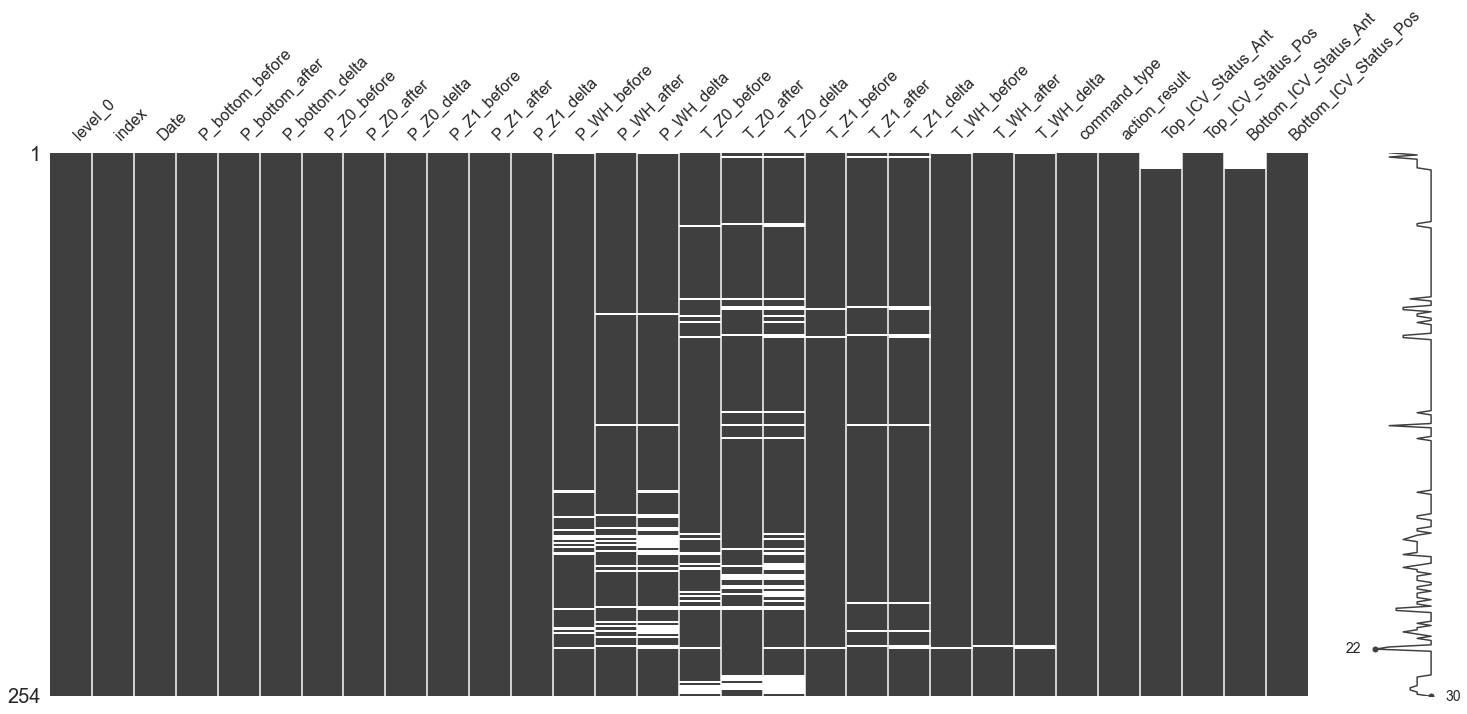

In [94]:
msno.matrix(df_test)

In [95]:
# Renaming the columns to match the synthetic dataset:
df_test.rename(columns={'Top_ICV_Status_Pos': 'top_icv_status_after', 'Bottom_ICV_Status_Pos': 'bottom_icv_status_after',
                        'Top_ICV_Status_Ant': 'top_icv_status_before', 'Bottom_ICV_Status_Ant': 'bottom_icv_status_before'}, inplace=True)
df_test

,level_0,index,Date,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,...,T_Z1_delta,T_WH_before,T_WH_after,T_WH_delta,command_type,action_result,top_icv_status_before,top_icv_status_after,bottom_icv_status_before,bottom_icv_status_after
0,0,0,2018-01-01,643.589100,643.608020,0.018920,853.061340,853.080260,0.018920,816.967413,...,-0.052840,NaN,3.575966,NaN,No-action,Normal,NaN,True,NaN,True
1,1,1,2018-01-02,643.609483,643.626475,0.016992,853.081724,853.098715,0.016992,816.987796,...,-0.048800,3.575966,3.540206,-0.035760,No-action,Normal,NaN,True,NaN,True
2,2,2,2018-01-03,643.626600,643.643800,0.017200,853.098840,853.116040,0.017200,817.004913,...,NaN,3.528286,3.528286,0.000000,No-action,Normal,NaN,True,NaN,True
3,3,3,2018-01-04,643.644300,643.659800,0.015500,853.116540,853.132040,0.015500,817.022613,...,-0.048850,3.528286,3.521475,-0.006811,No-action,Normal,NaN,True,NaN,True
4,4,4,2018-01-05,643.659800,643.673700,0.013900,853.132040,853.145940,0.013900,817.038113,...,-0.044800,3.528286,3.575966,0.047680,No-action,Normal,NaN,True,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,263,231,2018-08-20,552.084726,551.859215,-0.225511,761.556967,761.331456,-0.225511,725.463039,...,0.010695,76.224066,76.224122,0.000057,No-action,Normal,True,False,True,False
250,264,232,2018-08-21,551.821387,551.051082,-0.770305,761.293627,760.523322,-0.770305,725.199699,...,0.033129,76.224836,76.224770,-0.000066,Open_Top,Failure,False,True,False,True
251,266,233,2018-08-22,551.021986,556.434525,5.412539,760.494226,765.906765,5.412539,724.400298,...,-0.008650,76.225827,76.455550,0.229723,Close_Bottom,Failure,False,True,False,True
252,267,233,2018-08-22,551.021986,556.434525,5.412539,760.494226,765.906765,5.412539,724.400298,...,-0.008650,76.225827,76.455550,0.229723,Open_Bottom,Failure,False,True,False,True


In [96]:
df_test.fillna(method='bfill', inplace=True)

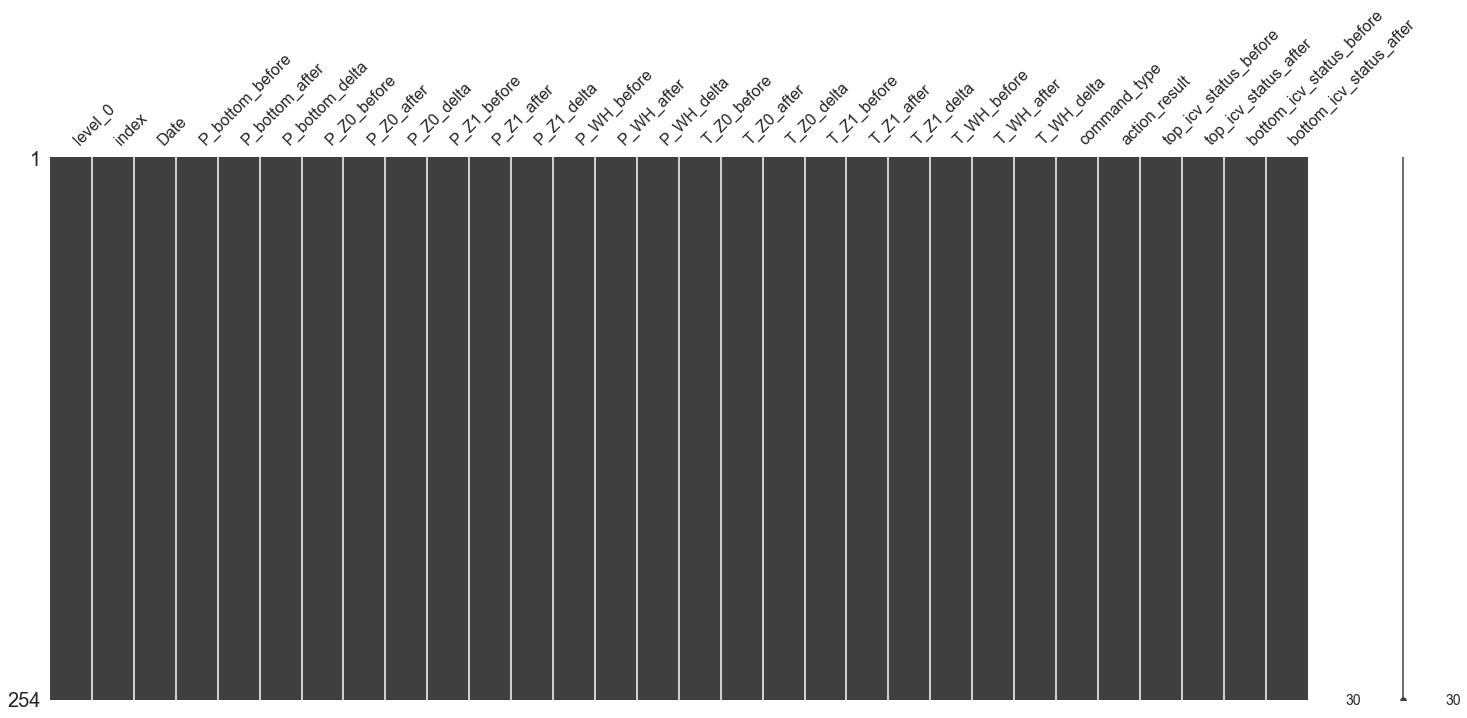

In [97]:
msno.matrix(df_test);

## Solving duplicates

In [98]:
df_test['command_type'].value_counts()

No-action       201
Open_Bottom      17
Open_Top         17
Close_Top        15
Close_Bottom      4
Name: command_type, dtype: int64

In [99]:
df_test['Date'].value_counts()[df_test['Date'].value_counts() > 1]

2018-07-11    3
2018-08-12    3
2018-08-13    3
2018-02-04    2
2018-08-15    2
2018-07-12    2
2018-07-13    2
2018-08-11    2
2018-01-15    2
2018-08-14    2
2018-01-13    2
2018-01-11    2
2018-08-16    2
2018-01-09    2
2018-02-13    2
2018-08-22    2
Name: Date, dtype: int64

In [100]:
df_test[df_test['Date'] == '2018-08-12']

,level_0,index,Date,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,...,T_Z1_delta,T_WH_before,T_WH_after,T_WH_delta,command_type,action_result,top_icv_status_before,top_icv_status_after,bottom_icv_status_before,bottom_icv_status_after
234,240,223,2018-08-12,545.09941,480.551134,-64.548276,754.571651,690.023375,-64.548276,718.477723,...,2.365554,75.653667,74.996509,-0.657159,Open_Top,Failure,False,True,False,True
235,241,223,2018-08-12,545.09941,480.551134,-64.548276,754.571651,690.023375,-64.548276,718.477723,...,2.365554,75.653667,74.996509,-0.657159,Close_Bottom,Failure,False,True,False,True
236,242,223,2018-08-12,545.09941,480.551134,-64.548276,754.571651,690.023375,-64.548276,718.477723,...,2.365554,75.653667,74.996509,-0.657159,Open_Bottom,Failure,False,True,False,True


In [101]:
df_test.loc[df_test['Date'] == '2018-08-12', 'command_type'].iloc[0]

'Open_Top'

In [102]:
# For more than an action in a day, just the last one is considered:
index = df_test['Date'].value_counts()[df_test['Date'].value_counts() > 1].index

In [103]:
index

DatetimeIndex(['2018-07-11', '2018-08-12', '2018-08-13', '2018-02-04',
               '2018-08-15', '2018-07-12', '2018-07-13', '2018-08-11',
               '2018-01-15', '2018-08-14', '2018-01-13', '2018-01-11',
               '2018-08-16', '2018-01-09', '2018-02-13', '2018-08-22'],
              dtype='datetime64[ns]', freq=None)

In [104]:
for day in index:
    df_test.loc[df_test['Date'] == day, 'command_type'] = df_test.loc[df_test['Date'] == day, 'command_type'].iloc[-1]

In [105]:
df_test[df_test['Date'] == '2018-08-12']

,level_0,index,Date,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,...,T_Z1_delta,T_WH_before,T_WH_after,T_WH_delta,command_type,action_result,top_icv_status_before,top_icv_status_after,bottom_icv_status_before,bottom_icv_status_after
234,240,223,2018-08-12,545.09941,480.551134,-64.548276,754.571651,690.023375,-64.548276,718.477723,...,2.365554,75.653667,74.996509,-0.657159,Open_Bottom,Failure,False,True,False,True
235,241,223,2018-08-12,545.09941,480.551134,-64.548276,754.571651,690.023375,-64.548276,718.477723,...,2.365554,75.653667,74.996509,-0.657159,Open_Bottom,Failure,False,True,False,True
236,242,223,2018-08-12,545.09941,480.551134,-64.548276,754.571651,690.023375,-64.548276,718.477723,...,2.365554,75.653667,74.996509,-0.657159,Open_Bottom,Failure,False,True,False,True


In [106]:
df_test.drop(columns=['level_0', 'index', 'Date'], inplace=True)
df_test.drop_duplicates(inplace=True)
df_test

,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,P_Z1_after,P_Z1_delta,P_WH_before,...,T_Z1_delta,T_WH_before,T_WH_after,T_WH_delta,command_type,action_result,top_icv_status_before,top_icv_status_after,bottom_icv_status_before,bottom_icv_status_after
0,643.589100,643.608020,0.018920,853.061340,853.080260,0.018920,816.967413,816.986333,0.018920,261.971283,...,-0.052840,3.575966,3.575966,-0.035760,No-action,Normal,True,True,True,True
1,643.609483,643.626475,0.016992,853.081724,853.098715,0.016992,816.987796,817.004788,0.016992,261.971283,...,-0.048800,3.575966,3.540206,-0.035760,No-action,Normal,True,True,True,True
2,643.626600,643.643800,0.017200,853.098840,853.116040,0.017200,817.004913,817.022113,0.017200,261.020700,...,-0.048850,3.528286,3.528286,0.000000,No-action,Normal,True,True,True,True
3,643.644300,643.659800,0.015500,853.116540,853.132040,0.015500,817.022613,817.038113,0.015500,259.846450,...,-0.048850,3.528286,3.521475,-0.006811,No-action,Normal,True,True,True,True
4,643.659800,643.673700,0.013900,853.132040,853.145940,0.013900,817.038113,817.052013,0.013900,259.343200,...,-0.044800,3.528286,3.575966,0.047680,No-action,Normal,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,554.930564,552.103200,-2.827364,764.402804,761.575440,-2.827364,728.308877,725.481513,-2.827364,160.589585,...,0.251498,76.030053,76.224453,0.194400,No-action,Normal,True,False,True,False
249,552.084726,551.859215,-0.225511,761.556967,761.331456,-0.225511,725.463039,725.237528,-0.225511,159.595826,...,0.010695,76.224066,76.224122,0.000057,No-action,Normal,True,False,True,False
250,551.821387,551.051082,-0.770305,761.293627,760.523322,-0.770305,725.199699,724.429394,-0.770305,160.179751,...,0.033129,76.224836,76.224770,-0.000066,Open_Top,Failure,False,True,False,True
251,551.021986,556.434525,5.412539,760.494226,765.906765,5.412539,724.400298,729.812838,5.412539,162.942267,...,-0.008650,76.225827,76.455550,0.229723,Open_Bottom,Failure,False,True,False,True


In [107]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235 entries, 0 to 253
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   P_bottom_before           235 non-null    float64
 1   P_bottom_after            235 non-null    float64
 2   P_bottom_delta            235 non-null    float64
 3   P_Z0_before               235 non-null    float64
 4   P_Z0_after                235 non-null    float64
 5   P_Z0_delta                235 non-null    float64
 6   P_Z1_before               235 non-null    float64
 7   P_Z1_after                235 non-null    float64
 8   P_Z1_delta                235 non-null    float64
 9   P_WH_before               235 non-null    float64
 10  P_WH_after                235 non-null    float64
 11  P_WH_delta                235 non-null    float64
 12  T_Z0_before               235 non-null    float64
 13  T_Z0_after                235 non-null    float64
 14  T_Z0_delta

## Encoding

In [108]:
dic_encoders = joblib.load('../outputs/models/dic_enconders_half-open.pkl')

In [109]:
dic_encoders

{'action_result': LabelEncoder(), 'command_type': OneHotEncoder(sparse=False)}

In [110]:
df_test['action_result'] = dic_encoders['action_result'].transform(df_test['action_result'])

In [111]:
new_cols = dic_encoders['command_type'].transform(df_test['command_type'].values.reshape(-1, 1)).T

In [112]:
new_cols.shape

(5, 235)

In [113]:
for k in range(new_cols.shape[0]):
    df_test[f'command_type_{k}'] = new_cols[k]
df_test.drop(columns=['command_type'], inplace=True)

In [114]:
df_test

,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,P_Z1_after,P_Z1_delta,P_WH_before,...,action_result,top_icv_status_before,top_icv_status_after,bottom_icv_status_before,bottom_icv_status_after,command_type_0,command_type_1,command_type_2,command_type_3,command_type_4
0,643.589100,643.608020,0.018920,853.061340,853.080260,0.018920,816.967413,816.986333,0.018920,261.971283,...,1,True,True,True,True,0.0,0.0,1.0,0.0,0.0
1,643.609483,643.626475,0.016992,853.081724,853.098715,0.016992,816.987796,817.004788,0.016992,261.971283,...,1,True,True,True,True,0.0,0.0,1.0,0.0,0.0
2,643.626600,643.643800,0.017200,853.098840,853.116040,0.017200,817.004913,817.022113,0.017200,261.020700,...,1,True,True,True,True,0.0,0.0,1.0,0.0,0.0
3,643.644300,643.659800,0.015500,853.116540,853.132040,0.015500,817.022613,817.038113,0.015500,259.846450,...,1,True,True,True,True,0.0,0.0,1.0,0.0,0.0
4,643.659800,643.673700,0.013900,853.132040,853.145940,0.013900,817.038113,817.052013,0.013900,259.343200,...,1,True,True,True,True,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,554.930564,552.103200,-2.827364,764.402804,761.575440,-2.827364,728.308877,725.481513,-2.827364,160.589585,...,1,True,False,True,False,0.0,0.0,1.0,0.0,0.0
249,552.084726,551.859215,-0.225511,761.556967,761.331456,-0.225511,725.463039,725.237528,-0.225511,159.595826,...,1,True,False,True,False,0.0,0.0,1.0,0.0,0.0
250,551.821387,551.051082,-0.770305,761.293627,760.523322,-0.770305,725.199699,724.429394,-0.770305,160.179751,...,0,False,True,False,True,0.0,0.0,0.0,0.0,1.0
251,551.021986,556.434525,5.412539,760.494226,765.906765,5.412539,724.400298,729.812838,5.412539,162.942267,...,0,False,True,False,True,0.0,0.0,0.0,1.0,0.0


In [115]:
# Saving to compare to the train dataset
joblib.dump(df_test, '../outputs/models/test_data.pkl')

['../outputs/models/test_data.pkl']

## Testing the models

In [116]:
y_test = df_test['action_result']
y_test

0      1
1      1
2      1
3      1
4      1
      ..
248    1
249    1
250    0
251    0
253    1
Name: action_result, Length: 235, dtype: int32

In [117]:
X_test = df_test.drop(columns='action_result')
X_test

,P_bottom_before,P_bottom_after,P_bottom_delta,P_Z0_before,P_Z0_after,P_Z0_delta,P_Z1_before,P_Z1_after,P_Z1_delta,P_WH_before,...,T_WH_delta,top_icv_status_before,top_icv_status_after,bottom_icv_status_before,bottom_icv_status_after,command_type_0,command_type_1,command_type_2,command_type_3,command_type_4
0,643.589100,643.608020,0.018920,853.061340,853.080260,0.018920,816.967413,816.986333,0.018920,261.971283,...,-0.035760,True,True,True,True,0.0,0.0,1.0,0.0,0.0
1,643.609483,643.626475,0.016992,853.081724,853.098715,0.016992,816.987796,817.004788,0.016992,261.971283,...,-0.035760,True,True,True,True,0.0,0.0,1.0,0.0,0.0
2,643.626600,643.643800,0.017200,853.098840,853.116040,0.017200,817.004913,817.022113,0.017200,261.020700,...,0.000000,True,True,True,True,0.0,0.0,1.0,0.0,0.0
3,643.644300,643.659800,0.015500,853.116540,853.132040,0.015500,817.022613,817.038113,0.015500,259.846450,...,-0.006811,True,True,True,True,0.0,0.0,1.0,0.0,0.0
4,643.659800,643.673700,0.013900,853.132040,853.145940,0.013900,817.038113,817.052013,0.013900,259.343200,...,0.047680,True,True,True,True,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,554.930564,552.103200,-2.827364,764.402804,761.575440,-2.827364,728.308877,725.481513,-2.827364,160.589585,...,0.194400,True,False,True,False,0.0,0.0,1.0,0.0,0.0
249,552.084726,551.859215,-0.225511,761.556967,761.331456,-0.225511,725.463039,725.237528,-0.225511,159.595826,...,0.000057,True,False,True,False,0.0,0.0,1.0,0.0,0.0
250,551.821387,551.051082,-0.770305,761.293627,760.523322,-0.770305,725.199699,724.429394,-0.770305,160.179751,...,-0.000066,False,True,False,True,0.0,0.0,0.0,0.0,1.0
251,551.021986,556.434525,5.412539,760.494226,765.906765,5.412539,724.400298,729.812838,5.412539,162.942267,...,0.229723,False,True,False,True,0.0,0.0,0.0,1.0,0.0


In [118]:
models = joblib.load('../outputs/models/models_half-open.pkl')

In [119]:
models

{'Logistic_Reg_clf': LogisticRegression(random_state=42),
 'DT_clf': DecisionTreeClassifier(random_state=42),
 'RF_clf': RandomForestClassifier(random_state=42),
 'KNN_clf': KNeighborsClassifier(),
 'NB_clf': GaussianNB(),
 'SV_clf': SVC(random_state=42),
 'Adaboost_clf': AdaBoostClassifier(random_state=42),
 'XGBoost_RF_clf': XGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                 colsample_bylevel=1, colsample_bytree=1,
                 early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                 importance_type=None, interaction_constraints='', max_bin=256,
                 max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
                 max_leaves=0, min_child_weight=1, missing=nan,
                 monotone_constraints='()', n_estimators=100, n_jobs=0,
                 num_parallel_tree=100, objective='binary:logistic',
                 predictor='auto', random_

In [120]:
for mod in models:
    print(f'Evaluating model {mod}...')
    print(f'Making predictions to the test set...')
    y_pred = models[mod].predict(X_test)
    print(f'Evaluating the metrics:')
    report = classification_report(y_test, y_pred, digits=3)
    print(report)

Evaluating model Logistic_Reg_clf...
Making predictions to the test set...
Evaluating the metrics:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        23
           1      0.902     1.000     0.949       212

    accuracy                          0.902       235
   macro avg      0.451     0.500     0.474       235
weighted avg      0.814     0.902     0.856       235

Evaluating model DT_clf...
Making predictions to the test set...
Evaluating the metrics:
              precision    recall  f1-score   support

           0      0.676     1.000     0.807        23
           1      1.000     0.948     0.973       212

    accuracy                          0.953       235
   macro avg      0.838     0.974     0.890       235
weighted avg      0.968     0.953     0.957       235

Evaluating model RF_clf...
Making predictions to the test set...
Evaluating the metrics:
              precision    recall  f1-score   support

           0  

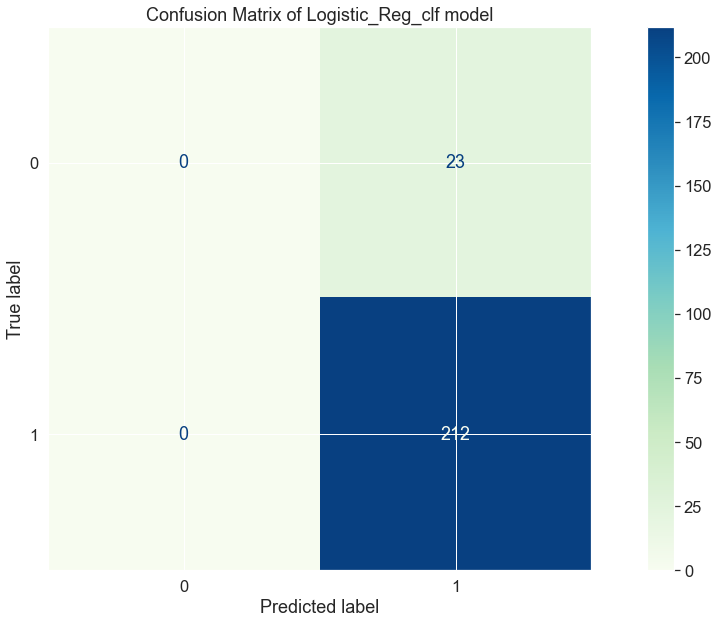

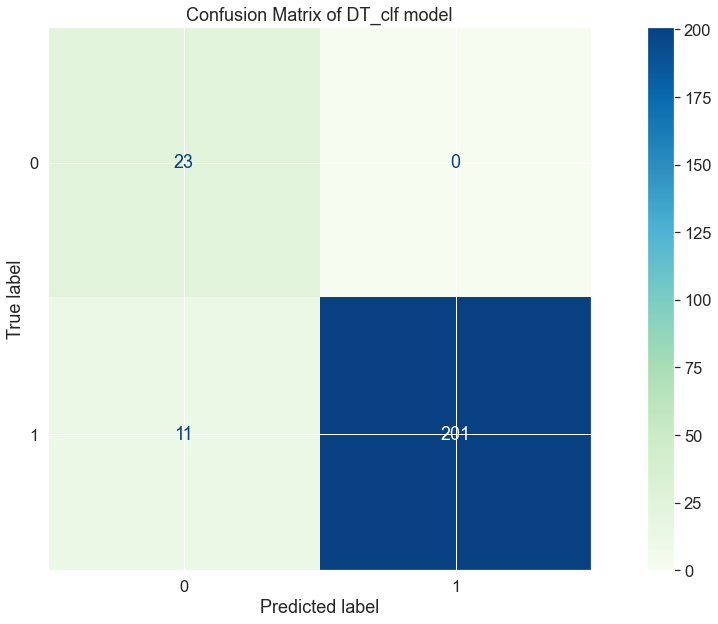

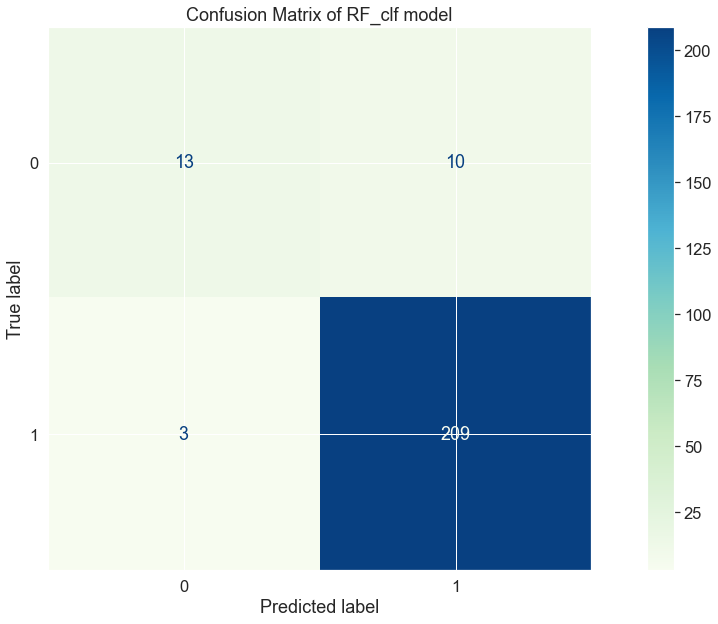

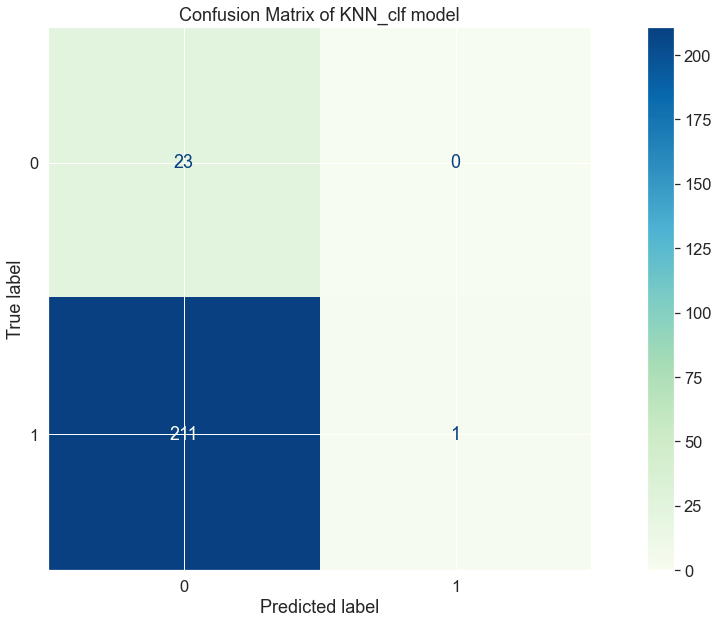

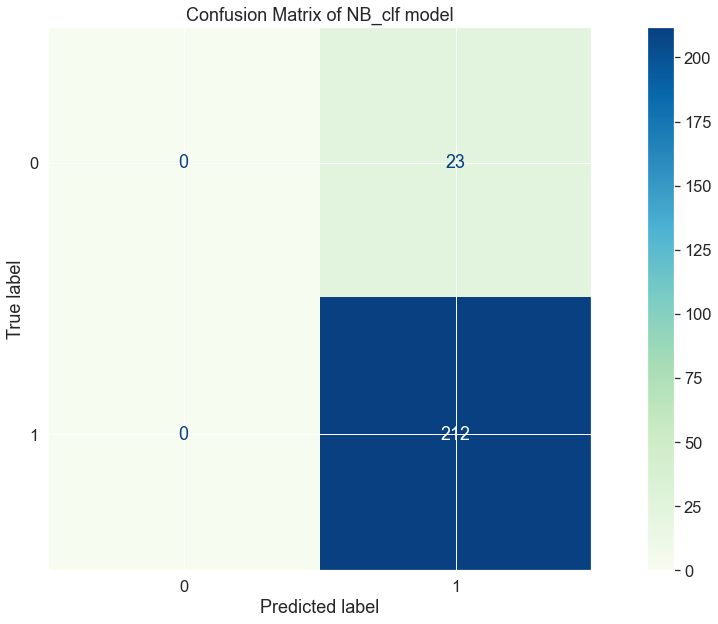

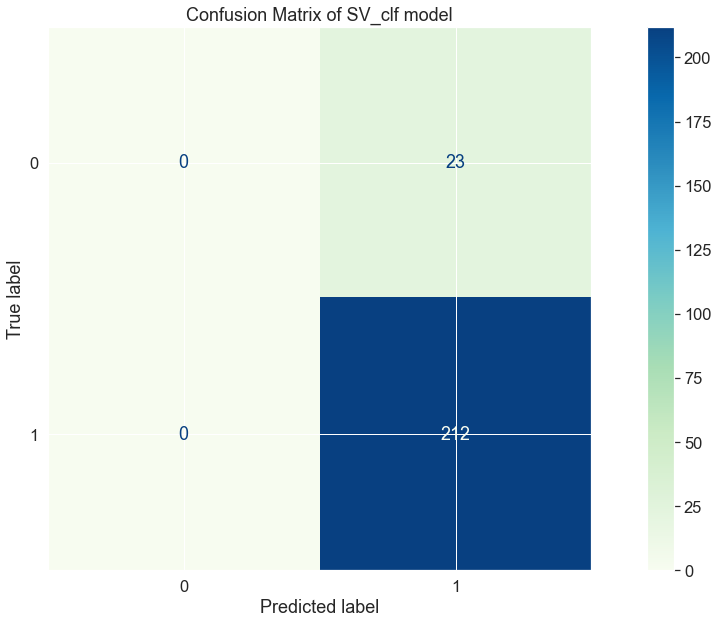

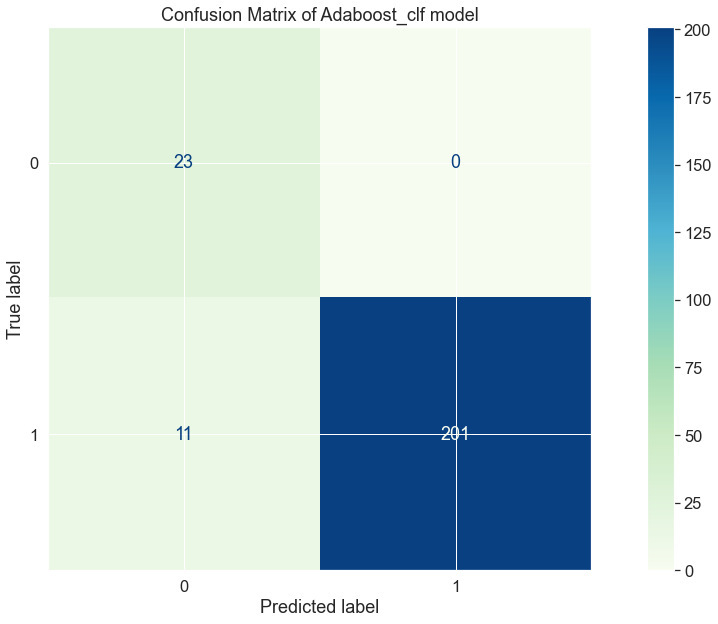

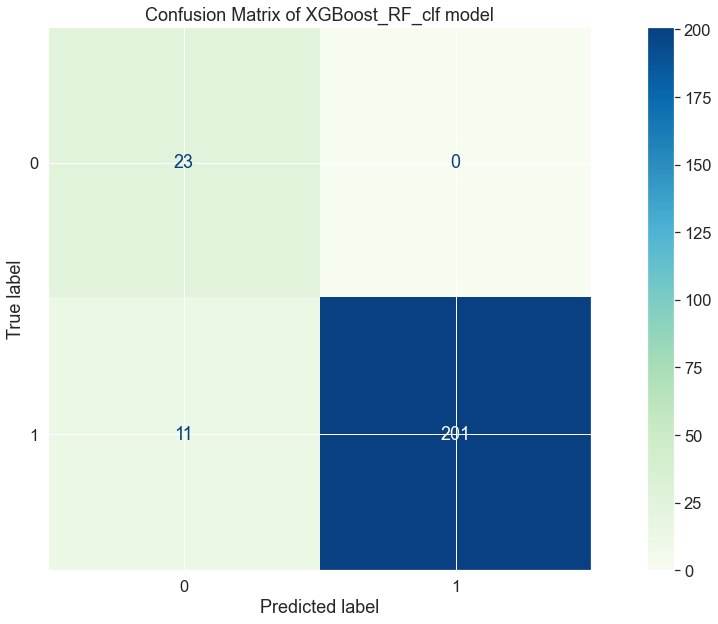

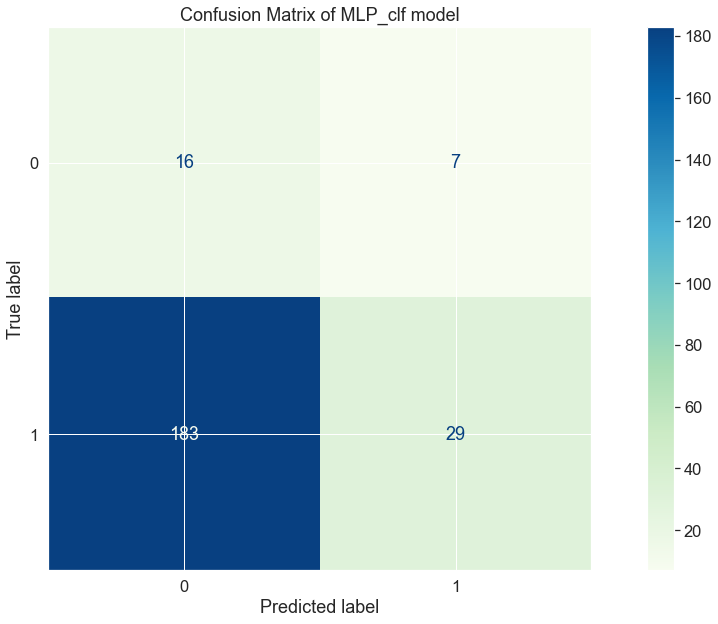

In [121]:
for mod in models:
    y_pred = models[mod].predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='GnBu')
    plt.title(f'Confusion Matrix of {mod} model')
    plt.show()